In [69]:
import torch, os, math, pickle, sys, random, time
from tqdm import tqdm
import torch.nn.init as init
import dgl,numpy as np
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, DataLoader as GDataLoader, Batch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Parameter
from collections import Counter
import dgl.function as fn
from dgl.nn.functional import edge_softmax
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.nn import RGCNConv, GraphConv, global_max_pool, GCNConv
from model import DialogueGCN_MELDModel, GraphNetwork_RGCN, GraphNetwork_GAT, \
GraphNetwork_GAT_EdgeFeat, GraphNetwork_GATv2, GraphNetwork_GATv2_EdgeFeat, GraphNetwork_RGAT, \
MatchingAttention, getDataLoaderAndLabels,GCNWithSkipConnections, GCNWithConcatenation
from model import DATASET_PATH
from torch.nn.utils.rnn import pad_sequence
from graph_context_dataset import GraphContextDataset
from sklearn.metrics import classification_report
from model import FCClassifier, MyNetwork, DATASET_PATH, MatchingAttention, RGCNWithGAT, \
RGATWithSkipConnections, EdgeGATWithGCN, EGATConv, EdgeGATWithSkipConnection,Edge2GATWithGCN

# EdgeGATWithSkipConnection, EGATConv, EdgeGATWithGCN, \
GCNWithConcatenation, GATWithBatchNormAndDropout
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
key=True
WINDOW_SIZE = 10

<b>Make sure to specify which dataset to use
<br>
 - dataset_original
<br>
 - dataset_drop_noise
<br>
 - dataset_smote

In [3]:
# dataset_path = "dataset_original"
# dataset_path = "dataset_drop_noise"
# dataset_path = "dataset_smote"
dataset_path = DATASET_PATH

In [4]:
class GATLayerWithEdgeType(nn.Module):
    def __init__(self, num_in_features_per_head, num_out_features_per_head, num_heads, num_edge_types):
        super(GATLayerWithEdgeType, self).__init__()
        self.num_in_features_per_head = num_in_features_per_head
        self.num_out_features_per_head = num_out_features_per_head
        self.num_heads = num_heads
        self.num_edge_types = num_edge_types

        # Linear projection for node features
        torch.manual_seed(42)
        self.linear_proj = nn.Linear(self.num_in_features_per_head, self.num_heads * self.num_out_features_per_head)
        
        # Edge type embeddings
        torch.manual_seed(42)
        self.edge_type_embedding = nn.Embedding(self.num_edge_types, self.num_heads)
        
    def forward(self, input_data, edge_type):
        node_features, edge_indices = input_data

        # Linear projection for node features
        h_linear = self.linear_proj(node_features.view(-1, self.num_in_features_per_head))
        h_linear = h_linear.view(-1, self.num_heads, self.num_out_features_per_head)
        h_linear = h_linear.permute(0, 2, 1)

        # Edge type embedding
        edge_type_embedding = self.edge_type_embedding(edge_type).transpose(0, 1)

        # Perform matrix multiplication
        attention_scores = torch.matmul(h_linear, edge_type_embedding).squeeze(-1)

        # Softmax to get attention coefficients
        attention_coefficients = F.softmax(attention_scores, dim=-1)

        # Weighted sum of neighbor node representations
        updated_representation = torch.matmul(attention_coefficients.transpose(1, 2), h_linear).mean(dim=2)

        return updated_representation, attention_coefficients
    
class GATWithEdgeType(nn.Module):
    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, num_edge_types):
        super(GATWithEdgeType, self).__init__()

        self.gat_net = nn.ModuleList()

        for layer in range(num_of_layers):
            num_in_features = num_heads_per_layer[layer - 1] * num_features_per_layer[layer - 1] if layer > 0 else num_features_per_layer[0]
            num_out_features = num_heads_per_layer[layer] * num_features_per_layer[layer]
            self.gat_net.append(GATLayerWithEdgeType(num_in_features, num_out_features, num_heads_per_layer[layer], num_edge_types))

    def forward(self, node_features, edge_indices, edge_types):
        h = node_features

        attention_scores = []

        for layer in self.gat_net:
            h, attention_coefficients = layer((h, edge_indices), edge_types)
            attention_scores.append(attention_coefficients)

        return h, attention_scores

class EGATConv(nn.Module):
    def __init__(self,
                 in_node_feats,
                 in_edge_feats,
                 out_node_feats,
                 out_edge_feats,
                 num_heads,
                 bias=True,
                 **kw_args):

        super().__init__()
        self._num_heads = num_heads
        self._out_node_feats = out_node_feats
        self._out_edge_feats = out_edge_feats
        
        self.fc_node = nn.Linear(in_node_feats, out_node_feats * num_heads, bias=bias)
        self.fc_ni = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        self.fc_fij = nn.Linear(in_edge_feats, out_edge_feats * num_heads, bias=False)
        self.fc_nj = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        
        # Attention parameter
        self.attn = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_edge_feats)))
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(size=(num_heads * out_edge_feats,)))
        else:
            self.register_buffer('bias', None)
        
        self.reset_parameters()

    def reset_parameters(self):
        torch.manual_seed(42)
        gain = init.calculate_gain('relu')
        init.xavier_normal_(self.fc_node.weight, gain=gain)
        init.xavier_normal_(self.fc_ni.weight, gain=gain)
        init.xavier_normal_(self.fc_fij.weight, gain=gain)
        init.xavier_normal_(self.fc_nj.weight, gain=gain)
        init.xavier_normal_(self.attn, gain=gain)
        
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)

    def forward(self, graph, nfeats, efeats, get_attention=False):
        with graph.local_scope():
            graph.edata['f'] = efeats
            graph.ndata['h'] = nfeats
            
            f_ni = self.fc_ni(nfeats)
            f_nj = self.fc_nj(nfeats)
            f_fij = self.fc_fij(efeats)
            graph.srcdata.update({'f_ni' : f_ni})
            graph.dstdata.update({'f_nj' : f_nj})
            
            graph.apply_edges(fn.u_add_v('f_ni', 'f_nj', 'f_tmp'))
            f_out = graph.edata.pop('f_tmp') + f_fij
            
            if self.bias is not None:
                f_out += self.bias
            f_out = nn.functional.leaky_relu(f_out)
            f_out = f_out.view(-1, self._num_heads, self._out_edge_feats)
            
            e = (f_out * self.attn).sum(dim=-1).unsqueeze(-1)
            graph.edata['a'] = edge_softmax(graph, e)
            graph.ndata['h_out'] = self.fc_node(nfeats).view(-1, self._num_heads, self._out_node_feats)
            
            graph.update_all(fn.u_mul_e('h_out', 'a', 'm'), fn.sum('m', 'h_out'))

            h_out = graph.ndata['h_out'].view(-1, self._num_heads, self._out_node_feats)
            if get_attention:
                return h_out, f_out, graph.edata.pop('a')
            else:
                return h_out, f_out


In [5]:
def get_ohe(edge_types):
    one_hot_encoding = []
    for edge_type in edge_types:
        if edge_type == 0:
            one_hot_encoding.append([1., 0., 0.])
        elif edge_type == 1:
            one_hot_encoding.append([0., 1., 0.])
        elif edge_type == 2:
            one_hot_encoding.append([0., 0., 1.])
    return torch.tensor(one_hot_encoding)

def get_inferred_edgetypes_GAT(dialog, edge_types):
    inferred_edge_types = []
    inferred_edge_indices = []
    for target_node in dialog.values():
        if len(target_node) == 1:
            inferred_edge_types.append(0)
            inferred_edge_indices.append(0)
        else:
            edge_index = target_node[0][0]
            highest_attention = target_node[0][1]
            for src_node in target_node[1:]:
                if highest_attention < src_node[1]:
                    highest_attention = src_node[1]
                    edge_index = src_node[0]
            inferred_edge_indices.append(edge_index)
            inferred_edge_types.append(edge_types[edge_index].tolist())
    return inferred_edge_indices, inferred_edge_types

def get_inferred_edgetypes_EGAT(edges_target_nodes, sample_edge_types, size_dialog, dialog_id):
    inferred_edge_types = []
    for target_idx in range(size_dialog):
        num_edges = len(edges_target_nodes[target_idx])
        if num_edges == 1:
            edgetype_idx = np.argmax(edges_target_nodes[target_idx][0][1])
            edge_idx = edges_target_nodes[target_idx][0][0]
            inferred_edge_types.append(edgetype_idx)
        else:
            highest_attn_score = max(edges_target_nodes[target_idx][0][1])
            edgetype_idx = np.argmax(edges_target_nodes[target_idx][0][1])
            edge_idx = edges_target_nodes[target_idx][0][0]
            for sample_edge in range(1, num_edges):
                cur_highest_attn_score = max(edges_target_nodes[target_idx][sample_edge][1])
                if cur_highest_attn_score > highest_attn_score:
                    highest_attn_score = cur_highest_attn_score
                    edgetype_idx = np.argmax(edges_target_nodes[target_idx][sample_edge][1])
                    edge_idx = edges_target_nodes[target_idx][sample_edge][0]
            inferred_edge_types.append(edgetype_idx)
    return inferred_edge_types

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list


In [6]:
def create_node_pairs_list(start_idx, end_idx):
    list_node_i = []
    list_node_j = []
    end_idx = end_idx - start_idx
    start_idx = 0
    for i in range(start_idx, end_idx+1):
        val = 0
        while (val <= WINDOW_SIZE) and (i+val <= end_idx):
            target_idx = i+val
            if target_idx >= 0:
                list_node_i.append(i)
                list_node_j.append(target_idx)
            val = val+1
    return [list_node_i, list_node_j]

def create_adjacency_dict(node_pairs):
    adjacency_list_dict = {}
    for i in range(0, len(node_pairs[0])):
        source_node, target_node = node_pairs[0][i], node_pairs[1][i]
        if source_node not in adjacency_list_dict:
            adjacency_list_dict[source_node] = [target_node]
        else:
            adjacency_list_dict[source_node].append(target_node)
    return adjacency_list_dict

def get_all_adjacency_list(ranges, key=0):
    all_adjacency_list = []
    for range_pair in ranges:
        start_idx, end_idx = range_pair
        if key == 0:
            output = create_node_pairs_list(start_idx, end_idx)
            output = create_adjacency_dict(output)
        elif key == 1:
            output = create_node_pairs_list(start_idx, end_idx)
            output = torch.tensor(output)
        else:
            print("N/A")
        all_adjacency_list.append(output)
    return all_adjacency_list

def get_all_edge_type_list(edge_indices, encoded_speaker_list):
    dialogs_len = len(edge_indices)
    whole_edge_type_list = []
    for i in range(dialogs_len):
        dialog_nodes_pairs = edge_indices[i]
        dialog_speakers = list(encoded_speaker_list[i])
        dialog_len = len(dialog_nodes_pairs.keys())
        edge_type_list = []
        for j in range(dialog_len):
            src_node = dialog_nodes_pairs[j]
            node_i_idx = j
            win_len = len(src_node)
            for k in range(win_len):
                node_j_idx = src_node[k]
                if node_i_idx == node_j_idx:
                    edge_type_list.append(0)
                else:
                    if dialog_speakers[node_i_idx] != dialog_speakers[node_j_idx]:
                        edge_type_list.append(1)
                    else:
                        edge_type_list.append(2)
        whole_edge_type_list.append(torch.tensor(edge_type_list).to(torch.int64))
    return whole_edge_type_list


In [7]:
def seed_everything(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

<h3> Data Preparation

<h4> Creating graph features from Train, Test and Validation sets

In [8]:
# checkFile = os.path.isfile("data/dump/" + dataset_path + "/speaker_encoder_train.pkl")
# encodedSpeakersTrain = []
# rangesTrain = []

# if not checkFile:
#     print("Run first the contextEncoder1 or 2 to generate this file")
# else:
#     with open('data/dump/' + dataset_path + '/speaker_encoder_train.pkl', "rb") as file:
#         encodedSpeakersTrain, rangesTrain = pickle.load(file)

# checkFile = os.path.isfile("data/dump/" + dataset_path +"/adjListTrain.pkl")
# adjacencyListTrain = []

# if key:
#     adjacencyListTrain = get_all_adjacency_list(rangesTrain)
# else:
#     with open('data/dump/' + dataset_path + '/adjListTrain', "rb") as file:
#         adjacencyListTrain = pickle.load(file)

In [9]:
def getSpeakersAndRanges(file_path):
    checkFile = os.path.isfile(file_path)
    encodedSpeakers = []
#     ranges = []
    if not checkFile:
        print("Run first the contextEncoder1.5 to generate this file")
        return None
    else:
        with open(file_path, "rb") as file:
            encodedSpeakers, ranges = pickle.load(file)
        return encodedSpeakers, ranges
    
def getAdjacencyList(file_path, ranges):
    checkFile = os.path.isfile(file_path)
    adjacencyList = []

    if key:
        adjacencyList = get_all_adjacency_list(ranges)
    else:
        with open(file_path, "rb") as file:
            adjacencyList = pickle.load(file)
    
    return adjacencyList

In [10]:
file_path1 = "data/dump/" + dataset_path + "/speaker_encoder_train.pkl"
file_path2 = "data/dump/" + dataset_path + "/speaker_encoder_test.pkl"
file_path3 = "data/dump/" + dataset_path + "/speaker_encoder_dev.pkl"

encodedSpeakersTrain, rangesTrain = getSpeakersAndRanges(file_path1)
encodedSpeakersTest, rangesTest = getSpeakersAndRanges(file_path2)
encodedSpeakersDev, rangesDev = getSpeakersAndRanges(file_path3)

file_path1 = 'data/dump/' + dataset_path + '/adjListTrain'
file_path2 = 'data/dump/' + dataset_path + '/adjListTest'
file_path3 = 'data/dump/' + dataset_path + '/adjListDev'

adjacencyListTrain = getAdjacencyList(file_path1, rangesTrain)
adjacencyListTest = getAdjacencyList(file_path1, rangesTest)
adjacencyListDev = getAdjacencyList(file_path1, rangesDev)

In [11]:
file_path1 = 'embed/' + dataset_path + '/u_prime_BERT_train.pkl'
file_path2 = 'embed/' + dataset_path + '/u_prime_BERT_test.pkl'
file_path3 = 'embed/' + dataset_path + '/u_prime_BERT_dev.pkl'

# Load the list from the file using pickle
def getFeatures(file_path):
    with open(file_path, 'rb') as file:
        emotions = pickle.load(file)
    return emotions

contextualEmbeddingsTrain = getFeatures(file_path1)
contextualEmbeddingsTest = getFeatures(file_path2)
contextualEmbeddingsDev = getFeatures(file_path3)

In [12]:
# print(contextualEmbeddingsTrain.shape, contextualEmbeddingsTest.shape, contextualEmbeddingsDev.shape)

In [13]:
edgeIndicesTrain = get_all_adjacency_list(rangesTrain)
edgeTypesTrain = get_all_edge_type_list(edgeIndicesTrain, encodedSpeakersTrain)
edgeIndicesTrain = get_all_adjacency_list(rangesTrain, key=1)

edgeIndicesTest = get_all_adjacency_list(rangesTest)
edgeTypesTest = get_all_edge_type_list(edgeIndicesTest, encodedSpeakersTest)
edgeIndicesTest = get_all_adjacency_list(rangesTest, key=1)

edgeIndicesDev = get_all_adjacency_list(rangesDev)
edgeTypesDev = get_all_edge_type_list(edgeIndicesDev, encodedSpeakersDev)
edgeIndicesDev = get_all_adjacency_list(rangesDev, key=1)

In [14]:
len(edgeIndicesDev[0][0])

3

#### Train without relational features

In [15]:
file_path = "data/dump/" + dataset_path + "/labels_train.pkl"
with open(file_path, 'rb') as file:
    y_train = pickle.load(file)
y_train = torch.tensor(y_train)

file_path = "data/dump/" + dataset_path + "/labels_test.pkl"
with open(file_path, 'rb') as file:
    y_test = pickle.load(file)
y_test = torch.tensor(y_test)

file_path = "data/dump/" + dataset_path + "/labels_dev.pkl"
with open(file_path, 'rb') as file:
    y_dev = pickle.load(file)
y_dev = torch.tensor(y_dev)

In [16]:
y_tensor_train = [y_train[start:end + 1] for start, end in rangesTrain]
y_tensor_dev = [y_dev[start:end + 1] for start, end in rangesDev]
y_tensor_test = [y_test[start:end + 1] for start, end in rangesTest]

In [17]:
def getDataset(contextualEmbedding, edgeIndices, yTensor, edgeTypes):
    dataset=[]
    for X, edges, Y, edgeTypes in zip(contextualEmbedding, edgeIndices, yTensor, edgeTypes):
        graph_data = Data(
            x=torch.tensor(X, dtype=torch.float),
            edge_index=torch.tensor(edges, dtype=torch.long),
            y=torch.tensor(Y, dtype=torch.long),
            edge_type = torch.tensor(edgeTypes, dtype=torch.long)
        )
        dataset.append(graph_data)
    return dataset

train_dataset = getDataset(contextualEmbeddingsTrain, edgeIndicesTrain, y_tensor_train, edgeTypesTrain)
dev_dataset = getDataset(contextualEmbeddingsDev, edgeIndicesDev, y_tensor_dev, edgeTypesDev)
test_dataset = getDataset(contextualEmbeddingsTest, edgeIndicesTest, y_tensor_test, edgeTypesTest)

train_loader = GDataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = GDataLoader(dev_dataset, batch_size=1, shuffle=True)
test_loader = GDataLoader(test_dataset, batch_size=1, shuffle=True)

C:\Users\edayo\AppData\Local\Temp\ipykernel_360\3524950887.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(X, dtype=torch.float),
C:\Users\edayo\AppData\Local\Temp\ipykernel_360\3524950887.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index=torch.tensor(edges, dtype=torch.long),
C:\Users\edayo\AppData\Local\Temp\ipykernel_360\3524950887.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(Y, dtype=torch.long),
C:\Users\edayo\AppData\Local\Temp\ipykernel_360\3524950887.py:8: UserWarning: To copy 

In [18]:
file_path = 'data/dump/' + dataset_path + '/label_decoder.pkl'
with open(file_path, 'rb') as file:
    label_decoder = pickle.load(file)
    
label_decoder.values()

dict_values(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'])

In [36]:
def train_model(model, train_loader, val_loader, lr=0.01, num_epochs=25, early_stop_threshold=0.0001, max_no_improve_epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = out.argmax(dim=1)
            correct_train += (preds == data.y).sum().item()
            total_train += data.y.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index)
                loss = criterion(out, data.y)
                val_loss += loss.item()

                preds = out.argmax(dim=1)
                correct_val += (preds == data.y).sum().item()
                total_val += data.y.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")

        if best_val_loss - val_losses[-1] < early_stop_threshold:
            no_improve_epochs += 1
            if no_improve_epochs >= max_no_improve_epochs:
                print("Early stopping triggered")
                break
        else:
            no_improve_epochs = 0
            best_val_loss = val_losses[-1]

    return model, train_losses, val_losses, train_accuracies, val_accuracies

def tune_model(model_class, train_loader, val_loader, num_features, num_classes):
    # Define hyperparameter space
    param_space = {
        'lr': [0.001, 0.01, 0.1],
        'num_epochs': [20, 25, 30],
        'early_stop_threshold': [0.0001, 0.0005, 0.001],
        'max_no_improve_epochs': [5, 10]
    }

    # Generate up to 5 random hyperparameter combinations
    param_combinations = [
        {
            'lr': random.choice(param_space['lr']),
            'num_epochs': random.choice(param_space['num_epochs']),
            'early_stop_threshold': random.choice(param_space['early_stop_threshold']),
            'max_no_improve_epochs': random.choice(param_space['max_no_improve_epochs'])
        }
        for _ in range(5)
    ]

    best_val_acc = 0
    best_params = None
    best_model = None

    for params in param_combinations:
        print(f"Training with params: {params}")
        model = model_class(num_features, num_classes)
        model, _, _, _, val_accuracies = train_model(
            model,
            train_loader,
            val_loader,
            lr=params['lr'],
            num_epochs=params['num_epochs'],
            early_stop_threshold=params['early_stop_threshold'],
            max_no_improve_epochs=params['max_no_improve_epochs']
        )

        val_acc = max(val_accuracies)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params
            best_model = model

    print(f"Best params: {best_params}, Best validation accuracy: {best_val_acc}")
    return best_model, best_params

def show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()

def show_classification_report_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            out = model(data.x, data.edge_index)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=label_decoder.values()))

no tuning

Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 200.30it/s]


Epoch 1: Train Loss = 1.7691284605393809, Val Loss = 2.5228864862014437, Train Acc = 0.49805295950155765, Val Acc = 0.5027359781121751


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 171.55it/s]


Epoch 2: Train Loss = 1.7306646691696355, Val Loss = 2.116791797153376, Train Acc = 0.5259345794392524, Val Acc = 0.41997264021887826


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 164.77it/s]


Epoch 3: Train Loss = 1.731827501833464, Val Loss = 2.6624922802203974, Train Acc = 0.5212616822429906, Val Acc = 0.5047879616963065


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 160.33it/s]


Epoch 4: Train Loss = 1.775955806845825, Val Loss = 2.1284780045436626, Train Acc = 0.5330218068535826, Val Acc = 0.46101231190150477


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 160.47it/s]


Epoch 5: Train Loss = 1.768592332697443, Val Loss = 1.8789049106512081, Train Acc = 0.5383177570093458, Val Acc = 0.47674418604651164


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 171.60it/s]


Epoch 6: Train Loss = 1.728835893070923, Val Loss = 1.9637559909321782, Train Acc = 0.5396417445482866, Val Acc = 0.4842681258549932


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 166.88it/s]


Epoch 7: Train Loss = 1.7960046211123915, Val Loss = 2.4067397497600824, Train Acc = 0.5396417445482866, Val Acc = 0.5116279069767442


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 171.86it/s]


Epoch 8: Train Loss = 1.8167606850012143, Val Loss = 1.7869550054961885, Train Acc = 0.5378504672897196, Val Acc = 0.478796169630643


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 172.23it/s]


Epoch 9: Train Loss = 1.7411644466119827, Val Loss = 3.8196020800462134, Train Acc = 0.5495327102803739, Val Acc = 0.405608755129959


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 166.78it/s]


Epoch 10: Train Loss = 1.8169342136415354, Val Loss = 2.9147202249672435, Train Acc = 0.5495327102803739, Val Acc = 0.45896032831737343


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 172.70it/s]


Epoch 11: Train Loss = 1.7433702607037702, Val Loss = 2.6418324495087964, Train Acc = 0.5429906542056074, Val Acc = 0.46785225718194257


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 165.75it/s]


Epoch 12: Train Loss = 1.7329980686806383, Val Loss = 2.196014402406635, Train Acc = 0.5534267912772586, Val Acc = 0.4425444596443228


Epoch 13: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 172.16it/s]


Epoch 13: Train Loss = 1.8114369371699628, Val Loss = 2.344201985074216, Train Acc = 0.5477414330218069, Val Acc = 0.45690834473324216
Early stopping triggered


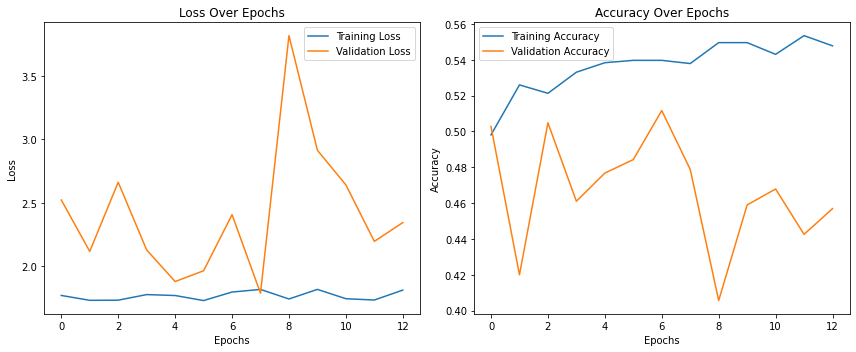

              precision    recall  f1-score   support

       anger       0.32      0.47      0.38       516
     disgust       0.10      0.24      0.14        99
        fear       0.06      0.10      0.08        60
         joy       0.43      0.22      0.29       495
     neutral       0.78      0.58      0.67      1615
     sadness       0.27      0.22      0.25       263
    surprise       0.37      0.67      0.48       352

    accuracy                           0.48      3400
   macro avg       0.33      0.36      0.33      3400
weighted avg       0.55      0.48      0.49      3400



In [26]:
model = GCNWithSkipConnections(num_features=768, num_classes=7)
model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_model(model, train_loader, val_loader)
show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)
show_classification_report_model(model, test_loader)



Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:09<00:00, 219.25it/s]


Epoch 1: Train Loss = 1.7856952599782676, Val Loss = 1.8923575099902572, Train Acc = 0.5297507788161994, Val Acc = 0.5068399452804377


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 195.96it/s]


Epoch 2: Train Loss = 1.6215635654258307, Val Loss = 2.068558475697258, Train Acc = 0.5506230529595015, Val Acc = 0.48768809849521205


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 194.89it/s]


Epoch 3: Train Loss = 1.5548164560495867, Val Loss = 1.9184377949339924, Train Acc = 0.569626168224299, Val Acc = 0.506155950752394


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 190.86it/s]


Epoch 4: Train Loss = 1.5204432186781938, Val Loss = 2.5160140011593253, Train Acc = 0.5799844236760124, Val Acc = 0.46716826265389877


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 195.25it/s]


Epoch 5: Train Loss = 1.492005541125703, Val Loss = 2.4455605374493947, Train Acc = 0.5733644859813084, Val Acc = 0.5013679890560876


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 197.30it/s]


Epoch 6: Train Loss = 1.4937362774154348, Val Loss = 2.029612169287537, Train Acc = 0.5777258566978193, Val Acc = 0.5259917920656635
Early stopping triggered


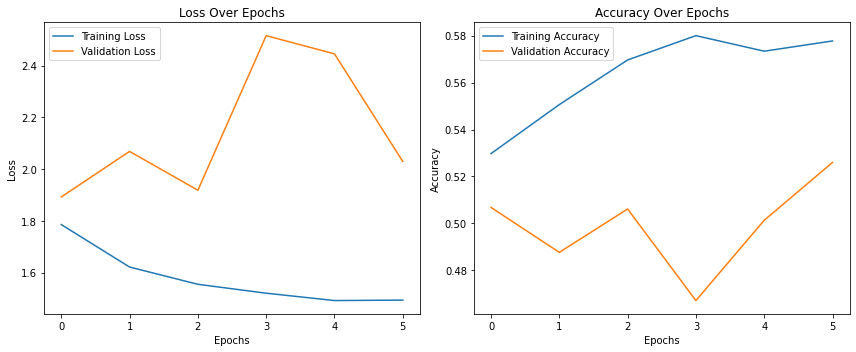

NameError: name 'show_classification_report_model' is not defined

In [20]:
model = GCNWithConcatenation(num_features=768, num_classes=7)
model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

In [23]:
show_classification_report_model(model, test_loader)

              precision    recall  f1-score   support

       anger       0.52      0.22      0.30       516
     disgust       0.38      0.22      0.28        99
        fear       0.24      0.08      0.12        60
         joy       0.49      0.49      0.49       495
     neutral       0.70      0.77      0.73      1615
     sadness       0.20      0.36      0.26       263
    surprise       0.45      0.48      0.46       352

    accuracy                           0.55      3400
   macro avg       0.43      0.37      0.38      3400
weighted avg       0.56      0.55      0.54      3400



with tuning

In [25]:
best_model, best_params = tune_model(GCNWithSkipConnections, train_loader, val_loader, 768, 7)

# Show the classification report of the tuned model on the test set
show_classification_report_model(best_model, test_loader, label_decoder)

Training with params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:09<00:00, 234.70it/s]


Epoch 1: Train Loss = 1.206167731416429, Val Loss = 1.278833054613184, Train Acc = 0.589797507788162, Val Acc = 0.5711354309165527


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 186.95it/s]


Epoch 2: Train Loss = 1.0975274664893127, Val Loss = 1.3741717386576864, Train Acc = 0.6123831775700934, Val Acc = 0.5533515731874145


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 157.93it/s]


Epoch 3: Train Loss = 1.062419028773352, Val Loss = 1.3052301940818627, Train Acc = 0.6214953271028038, Val Acc = 0.554719562243502


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 167.90it/s]


Epoch 4: Train Loss = 1.034115382956548, Val Loss = 1.3038621239226174, Train Acc = 0.6220404984423676, Val Acc = 0.554719562243502


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 167.70it/s]


Epoch 5: Train Loss = 1.010558520524797, Val Loss = 1.351673086622247, Train Acc = 0.6346573208722741, Val Acc = 0.5622435020519836


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 171.78it/s]


Epoch 6: Train Loss = 0.9879443237476085, Val Loss = 1.385997843466423, Train Acc = 0.6322429906542056, Val Acc = 0.5601915184678523


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 175.57it/s]


Epoch 7: Train Loss = 0.9664544781635481, Val Loss = 1.3514124799657752, Train Acc = 0.6425233644859814, Val Acc = 0.5506155950752394


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 183.21it/s]


Epoch 8: Train Loss = 0.9521608284630492, Val Loss = 1.5138310836145172, Train Acc = 0.6458722741433022, Val Acc = 0.5082079343365253


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 186.91it/s]


Epoch 9: Train Loss = 0.931477195435289, Val Loss = 1.4001582884057253, Train Acc = 0.645404984423676, Val Acc = 0.5629274965800274


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 181.99it/s]


Epoch 10: Train Loss = 0.9216482946853931, Val Loss = 1.3706282753635335, Train Acc = 0.6532710280373831, Val Acc = 0.5656634746922025


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.60it/s]


Epoch 11: Train Loss = 0.9112440611684367, Val Loss = 1.3807846345283368, Train Acc = 0.6540498442367602, Val Acc = 0.5533515731874145
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 189.50it/s]


Epoch 1: Train Loss = 1.7920956351925, Val Loss = 1.8313940100078643, Train Acc = 0.49034267912772583, Val Acc = 0.5143638850889193


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 174.94it/s]


Epoch 2: Train Loss = 1.7905262728997817, Val Loss = 2.5521665759384633, Train Acc = 0.5188473520249222, Val Acc = 0.27359781121751026


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 175.07it/s]


Epoch 3: Train Loss = 1.759185666393326, Val Loss = 2.3471860630058305, Train Acc = 0.5263239875389408, Val Acc = 0.49863201094391246


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 170.00it/s]


Epoch 4: Train Loss = 1.7644989540958502, Val Loss = 2.025025749949014, Train Acc = 0.5284267912772586, Val Acc = 0.5129958960328317


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 173.47it/s]


Epoch 5: Train Loss = 1.8425305322134657, Val Loss = 2.132122889857877, Train Acc = 0.5304517133956387, Val Acc = 0.5129958960328317


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 170.49it/s]


Epoch 6: Train Loss = 1.7749311291841474, Val Loss = 2.736047258501047, Train Acc = 0.5348909657320873, Val Acc = 0.47537619699042405


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 174.40it/s]


Epoch 7: Train Loss = 1.7554186922207817, Val Loss = 3.3043077580613534, Train Acc = 0.5373052959501557, Val Acc = 0.44049247606019154


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 173.39it/s]


Epoch 8: Train Loss = 1.7895642248412733, Val Loss = 2.844063862499607, Train Acc = 0.540576323987539, Val Acc = 0.5129958960328317


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 169.17it/s]


Epoch 9: Train Loss = 1.7016405963904415, Val Loss = 2.9471881487303513, Train Acc = 0.5492990654205607, Val Acc = 0.5136798905608755


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 172.13it/s]


Epoch 10: Train Loss = 1.8044019132730547, Val Loss = 2.2017475076692388, Train Acc = 0.5460280373831776, Val Acc = 0.5287277701778386


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 167.73it/s]


Epoch 11: Train Loss = 1.7564010118923592, Val Loss = 2.5061366312345923, Train Acc = 0.5508566978193147, Val Acc = 0.4897400820793434
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 187.66it/s]


Epoch 1: Train Loss = 106.91857009660443, Val Loss = 101.37258278108673, Train Acc = 0.40973520249221185, Val Acc = 0.4473324213406293


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 172.29it/s]


Epoch 2: Train Loss = 122.7198718674852, Val Loss = 258.30818455004413, Train Acc = 0.4441588785046729, Val Acc = 0.42270861833105333


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 172.80it/s]


Epoch 3: Train Loss = 147.74169610547096, Val Loss = 132.3628444733443, Train Acc = 0.46370716510903426, Val Acc = 0.46238030095759236


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 176.52it/s]


Epoch 4: Train Loss = 270.5665422792391, Val Loss = 329.7151803681297, Train Acc = 0.4691588785046729, Val Acc = 0.49726402188782487


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 173.25it/s]


Epoch 5: Train Loss = 129.64513157563147, Val Loss = 122.88261177345014, Train Acc = 0.4996884735202492, Val Acc = 0.3967168262653899


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 174.23it/s]


Epoch 6: Train Loss = 114.51697055409532, Val Loss = 107.74902431523628, Train Acc = 0.4861370716510903, Val Acc = 0.5253077975376197
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 193.44it/s]


Epoch 1: Train Loss = 96.6548701992589, Val Loss = 90.7161042898686, Train Acc = 0.40654205607476634, Val Acc = 0.42339261285909713


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 171.38it/s]


Epoch 2: Train Loss = 127.6018081488298, Val Loss = 119.77442854540328, Train Acc = 0.4533489096573209, Val Acc = 0.53077975376197


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 174.56it/s]


Epoch 3: Train Loss = 135.79409295973005, Val Loss = 108.06395969499523, Train Acc = 0.46814641744548285, Val Acc = 0.4781121751025992


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 171.83it/s]


Epoch 4: Train Loss = 128.7656777579809, Val Loss = 118.69718314378633, Train Acc = 0.4738317757009346, Val Acc = 0.5006839945280438


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 174.43it/s]


Epoch 5: Train Loss = 141.69174049093112, Val Loss = 92.28242900290901, Train Acc = 0.4761682242990654, Val Acc = 0.46101231190150477


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 175.53it/s]


Epoch 6: Train Loss = 144.10221487159382, Val Loss = 170.29128404502515, Train Acc = 0.48909657320872274, Val Acc = 0.41928864569083446


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 170.26it/s]


Epoch 7: Train Loss = 137.825853122124, Val Loss = 142.55337829135635, Train Acc = 0.48785046728971965, Val Acc = 0.4829001367989056


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 176.94it/s]


Epoch 8: Train Loss = 148.38329548808912, Val Loss = 178.94770553663693, Train Acc = 0.48785046728971965, Val Acc = 0.4261285909712722


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 173.14it/s]


Epoch 9: Train Loss = 141.243754807342, Val Loss = 351.9815741241265, Train Acc = 0.4899532710280374, Val Acc = 0.4117647058823529


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 176.74it/s]


Epoch 10: Train Loss = 150.40041208819042, Val Loss = 211.22112941752982, Train Acc = 0.49929906542056074, Val Acc = 0.5444596443228454


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 176.86it/s]


Epoch 11: Train Loss = 147.5676749549391, Val Loss = 253.77284946463726, Train Acc = 0.4987538940809969, Val Acc = 0.27428180574555405
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 181.96it/s]


Epoch 1: Train Loss = 90.91716545044424, Val Loss = 125.67638269845513, Train Acc = 0.41261682242990655, Val Acc = 0.40355677154582764


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 171.29it/s]


Epoch 2: Train Loss = 138.50832585160396, Val Loss = 130.2283628844062, Train Acc = 0.4472741433021807, Val Acc = 0.44596443228454175


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 164.51it/s]


Epoch 3: Train Loss = 133.31891496439926, Val Loss = 137.75105781568973, Train Acc = 0.4654205607476635, Val Acc = 0.3344733242134063


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 172.21it/s]


Epoch 4: Train Loss = 131.07588573204342, Val Loss = 155.3296485377868, Train Acc = 0.472196261682243, Val Acc = 0.46990424076607384


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 174.80it/s]


Epoch 5: Train Loss = 133.84048198281567, Val Loss = 135.9209174826051, Train Acc = 0.472196261682243, Val Acc = 0.3857729138166895


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 165.08it/s]


Epoch 6: Train Loss = 138.68953517266624, Val Loss = 138.968629457361, Train Acc = 0.4808411214953271, Val Acc = 0.5328317373461012


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 157.28it/s]


Epoch 7: Train Loss = 143.15979598737178, Val Loss = 196.34330719708944, Train Acc = 0.4883956386292835, Val Acc = 0.4110807113543092


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 173.48it/s]


Epoch 8: Train Loss = 145.3538969480547, Val Loss = 206.45959179857633, Train Acc = 0.4968847352024922, Val Acc = 0.3803009575923393


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 164.65it/s]


Epoch 9: Train Loss = 141.67840953582387, Val Loss = 159.1247196783888, Train Acc = 0.4957943925233645, Val Acc = 0.5129958960328317


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 167.53it/s]


Epoch 10: Train Loss = 154.88601545408275, Val Loss = 143.12692358241864, Train Acc = 0.49439252336448597, Val Acc = 0.4425444596443228


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 167.87it/s]


Epoch 11: Train Loss = 151.22336105419376, Val Loss = 181.7186985432528, Train Acc = 0.4998442367601246, Val Acc = 0.4883720930232558
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}, Best validation accuracy: 0.5711354309165527
              precision    recall  f1-score   support

       anger       0.53      0.25      0.34       516
     disgust       0.30      0.06      0.10        99
        fear       0.33      0.13      0.19        60
         joy       0.40      0.64      0.49       495
     neutral       0.71      0.81      0.76      1615
     sadness       0.29      0.24      0.26       263
    surprise       0.56      0.44      0.49       352

    accuracy                           0.58      3400
   macro avg       0.45      0.37      0.38      3400
weighted avg       0.57      0.58      0.56      3400



In [27]:
best_model, best_params = tune_model(GCNWithConcatenation, train_loader, val_loader, 768, 7)

show_classification_report_model(best_model, test_loader, label_decoder)

Training with params: {'lr': 0.1, 'num_epochs': 25, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:09<00:00, 237.95it/s]


Epoch 1: Train Loss = 13.302221122794434, Val Loss = 13.12725579518462, Train Acc = 0.4829439252336449, Val Acc = 0.49179206566347466


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 203.84it/s]


Epoch 2: Train Loss = 12.594840180326734, Val Loss = 14.774831505441954, Train Acc = 0.5136292834890965, Val Acc = 0.5136798905608755


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 193.27it/s]


Epoch 3: Train Loss = 13.176621984029195, Val Loss = 19.99596075124101, Train Acc = 0.5297507788161994, Val Acc = 0.41928864569083446


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 196.39it/s]


Epoch 4: Train Loss = 12.315876065077214, Val Loss = 19.174803172424994, Train Acc = 0.5253115264797508, Val Acc = 0.466484268125855


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 189.04it/s]


Epoch 5: Train Loss = 12.487183075943815, Val Loss = 17.562425893020013, Train Acc = 0.5394080996884735, Val Acc = 0.42544459644322846


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 189.81it/s]


Epoch 6: Train Loss = 12.127487536809197, Val Loss = 14.345220700894284, Train Acc = 0.5464953271028037, Val Acc = 0.5218878248974008


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 192.60it/s]


Epoch 7: Train Loss = 12.43893659768826, Val Loss = 15.38172150381074, Train Acc = 0.5481308411214953, Val Acc = 0.5280437756497948


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 179.46it/s]


Epoch 8: Train Loss = 12.367483372702411, Val Loss = 23.10783062783718, Train Acc = 0.5543613707165109, Val Acc = 0.43433652530779754


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 188.79it/s]


Epoch 9: Train Loss = 12.3439513187036, Val Loss = 24.54522532333798, Train Acc = 0.5506230529595015, Val Acc = 0.4945280437756498


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 189.89it/s]


Epoch 10: Train Loss = 12.462573906700793, Val Loss = 20.29267356374864, Train Acc = 0.5549065420560748, Val Acc = 0.5041039671682627


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 173.45it/s]


Epoch 11: Train Loss = 12.283722773205104, Val Loss = 20.16577237330376, Train Acc = 0.5608255451713395, Val Acc = 0.49179206566347466
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 20, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 196.02it/s]


Epoch 1: Train Loss = 14.060784138380772, Val Loss = 17.05056210091148, Train Acc = 0.48177570093457944, Val Acc = 0.3625170998632011


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 177.14it/s]


Epoch 2: Train Loss = 12.88600181865819, Val Loss = 19.348016157670212, Train Acc = 0.517601246105919, Val Acc = 0.3796169630642955


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 186.75it/s]


Epoch 3: Train Loss = 13.046995363466925, Val Loss = 19.878548540628064, Train Acc = 0.5243769470404984, Val Acc = 0.4582763337893297


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 173.39it/s]


Epoch 4: Train Loss = 12.067892172369527, Val Loss = 15.16478817337241, Train Acc = 0.5431464174454829, Val Acc = 0.5239398084815321


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 171.76it/s]


Epoch 5: Train Loss = 12.718660971343745, Val Loss = 24.674997372232003, Train Acc = 0.5392523364485982, Val Acc = 0.44596443228454175


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 181.81it/s]


Epoch 6: Train Loss = 11.96836193991478, Val Loss = 23.308541677961927, Train Acc = 0.5507009345794392, Val Acc = 0.3652530779753762


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 183.35it/s]


Epoch 7: Train Loss = 12.9925445355997, Val Loss = 19.04791157004284, Train Acc = 0.5441588785046729, Val Acc = 0.49247606019151846


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:14<00:00, 148.85it/s]


Epoch 8: Train Loss = 12.125625126681246, Val Loss = 18.195560178613928, Train Acc = 0.5524922118380062, Val Acc = 0.5129958960328317


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 176.78it/s]


Epoch 9: Train Loss = 11.676931691900064, Val Loss = 19.21805939744606, Train Acc = 0.5580218068535826, Val Acc = 0.39261285909712723
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 198.12it/s]


Epoch 1: Train Loss = 14.94361197810718, Val Loss = 22.581012975444295, Train Acc = 0.47570093457943924, Val Acc = 0.47058823529411764


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 186.30it/s]


Epoch 2: Train Loss = 12.849354425470485, Val Loss = 17.309886543945534, Train Acc = 0.5180685358255451, Val Acc = 0.399452804377565


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 170.92it/s]


Epoch 3: Train Loss = 12.96984497636649, Val Loss = 19.591538961336468, Train Acc = 0.5200934579439253, Val Acc = 0.518467852257182


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 176.20it/s]


Epoch 4: Train Loss = 12.1169249608517, Val Loss = 18.631985168689006, Train Acc = 0.5371495327102803, Val Acc = 0.4575923392612859


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.92it/s]


Epoch 5: Train Loss = 12.466309194268254, Val Loss = 15.47865072684919, Train Acc = 0.5438473520249221, Val Acc = 0.47606019151846785


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.36it/s]


Epoch 6: Train Loss = 12.396428415944598, Val Loss = 17.790873848145768, Train Acc = 0.545638629283489, Val Acc = 0.5314637482900136


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 191.57it/s]


Epoch 7: Train Loss = 11.978192205310892, Val Loss = 22.365182561516143, Train Acc = 0.552803738317757, Val Acc = 0.47127222982216144


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.84it/s]


Epoch 8: Train Loss = 11.856834911978998, Val Loss = 15.162323365351698, Train Acc = 0.5591121495327103, Val Acc = 0.4781121751025992


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 174.80it/s]


Epoch 9: Train Loss = 12.200596498657239, Val Loss = 25.778395047423114, Train Acc = 0.5620716510903426, Val Acc = 0.5232558139534884


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 183.59it/s]


Epoch 10: Train Loss = 12.640767220846978, Val Loss = 18.726907838677825, Train Acc = 0.5524922118380062, Val Acc = 0.4883720930232558


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 181.85it/s]


Epoch 11: Train Loss = 12.22377754536599, Val Loss = 25.670884902071943, Train Acc = 0.5624610591900312, Val Acc = 0.40013679890560877


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 188.99it/s]


Epoch 12: Train Loss = 11.803869249830576, Val Loss = 19.13830279236246, Train Acc = 0.5685358255451713, Val Acc = 0.47674418604651164


Epoch 13: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 187.02it/s]


Epoch 13: Train Loss = 11.705583127869772, Val Loss = 26.71826207478078, Train Acc = 0.5662772585669782, Val Acc = 0.42339261285909713
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 193.14it/s]


Epoch 1: Train Loss = 14.353013208021881, Val Loss = 14.25896231370489, Train Acc = 0.478816199376947, Val Acc = 0.5253077975376197


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 182.59it/s]


Epoch 2: Train Loss = 12.877642064901634, Val Loss = 15.552211709981616, Train Acc = 0.5218068535825545, Val Acc = 0.4466484268125855


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 183.04it/s]


Epoch 3: Train Loss = 12.456508920185913, Val Loss = 19.210968729495363, Train Acc = 0.517601246105919, Val Acc = 0.43502051983584133


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 171.94it/s]


Epoch 4: Train Loss = 12.239364545771153, Val Loss = 16.133940577476714, Train Acc = 0.5368380062305296, Val Acc = 0.5232558139534884


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 180.45it/s]


Epoch 5: Train Loss = 12.541207063514333, Val Loss = 24.475862505359263, Train Acc = 0.5443146417445482, Val Acc = 0.5129958960328317


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 175.56it/s]


Epoch 6: Train Loss = 11.932078752724689, Val Loss = 20.238261755020037, Train Acc = 0.5477414330218069, Val Acc = 0.4740082079343365


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 184.37it/s]


Epoch 7: Train Loss = 11.943923186078981, Val Loss = 19.8161900574447, Train Acc = 0.5521028037383178, Val Acc = 0.5259917920656635


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 180.32it/s]


Epoch 8: Train Loss = 12.044409694340832, Val Loss = 17.455540984514446, Train Acc = 0.5443146417445482, Val Acc = 0.49316005471956226


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 173.77it/s]


Epoch 9: Train Loss = 11.900154755407002, Val Loss = 17.93901206479262, Train Acc = 0.5535046728971963, Val Acc = 0.5164158686730507


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 184.28it/s]


Epoch 10: Train Loss = 11.991451850971776, Val Loss = 22.96811490901658, Train Acc = 0.5589563862928348, Val Acc = 0.38303693570451436


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 184.85it/s]


Epoch 11: Train Loss = 11.89452207011536, Val Loss = 27.21722078786867, Train Acc = 0.5683800623052959, Val Acc = 0.5170998632010944
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 198.02it/s]


Epoch 1: Train Loss = 13.770865839338109, Val Loss = 20.226924609846776, Train Acc = 0.48333333333333334, Val Acc = 0.39398084815321477


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 175.42it/s]


Epoch 2: Train Loss = 12.732691928465522, Val Loss = 16.5958028517994, Train Acc = 0.509968847352025, Val Acc = 0.39398084815321477


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 171.21it/s]


Epoch 3: Train Loss = 12.308722139915035, Val Loss = 25.230033081056924, Train Acc = 0.5276479750778816, Val Acc = 0.32968536251709984


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 178.46it/s]


Epoch 4: Train Loss = 12.77322596697502, Val Loss = 19.522284070393788, Train Acc = 0.5389408099688473, Val Acc = 0.46443228454172364


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 182.50it/s]


Epoch 5: Train Loss = 12.159144389102153, Val Loss = 17.38363765043781, Train Acc = 0.5357476635514019, Val Acc = 0.5198358413132695


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 177.48it/s]


Epoch 6: Train Loss = 12.259210987363286, Val Loss = 19.150870167007376, Train Acc = 0.5462616822429907, Val Acc = 0.5047879616963065


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 182.76it/s]


Epoch 7: Train Loss = 12.970041814219547, Val Loss = 16.390639376672507, Train Acc = 0.541588785046729, Val Acc = 0.5047879616963065


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:14<00:00, 151.95it/s]


Epoch 8: Train Loss = 12.053894884334543, Val Loss = 19.842816020296347, Train Acc = 0.5515576323987539, Val Acc = 0.5082079343365253


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 174.38it/s]


Epoch 9: Train Loss = 11.670562211615392, Val Loss = 21.635378705797326, Train Acc = 0.5580996884735202, Val Acc = 0.420656634746922


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 173.76it/s]


Epoch 10: Train Loss = 12.295929820827684, Val Loss = 25.121723265704457, Train Acc = 0.5556853582554517, Val Acc = 0.3023255813953488


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 170.94it/s]


Epoch 11: Train Loss = 12.327484497555702, Val Loss = 27.368652220315045, Train Acc = 0.5515576323987539, Val Acc = 0.38372093023255816


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 175.52it/s]


Epoch 12: Train Loss = 11.77931335159017, Val Loss = 18.2997096915208, Train Acc = 0.5676791277258567, Val Acc = 0.48632010943912446


Epoch 13: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 169.86it/s]


Epoch 13: Train Loss = 12.444189290149632, Val Loss = 22.505921908745073, Train Acc = 0.5700934579439252, Val Acc = 0.4186046511627907


Epoch 14: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 186.44it/s]


Epoch 14: Train Loss = 12.152169442621503, Val Loss = 19.924580384858412, Train Acc = 0.5700934579439252, Val Acc = 0.43023255813953487


Epoch 15: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 189.88it/s]


Epoch 15: Train Loss = 11.447044489724204, Val Loss = 22.99495168174541, Train Acc = 0.5784267912772586, Val Acc = 0.5088919288645691


Epoch 16: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 184.58it/s]


Epoch 16: Train Loss = 11.980619750757985, Val Loss = 20.423597460014815, Train Acc = 0.5754672897196261, Val Acc = 0.44596443228454175


Epoch 17: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 188.99it/s]


Epoch 17: Train Loss = 12.445835483627317, Val Loss = 21.86337172191997, Train Acc = 0.5702492211838006, Val Acc = 0.5246238030095759
Early stopping triggered
Best params: {'lr': 0.1, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}, Best validation accuracy: 0.5314637482900136
              precision    recall  f1-score   support

       anger       0.70      0.04      0.08       516
     disgust       0.07      0.58      0.12        99
        fear       0.13      0.32      0.18        60
         joy       0.45      0.52      0.48       495
     neutral       0.73      0.66      0.69      1615
     sadness       0.24      0.20      0.22       263
    surprise       0.73      0.21      0.32       352

    accuracy                           0.45      3400
   macro avg       0.43      0.36      0.30      3400
weighted avg       0.62      0.45      0.47      3400



In [28]:
# model = GCNWithSkipConnections(num_features=768, num_classes=7)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.CrossEntropyLoss()

# train_losses = []
# val_losses = []
# train_accuracies = []
# val_accuracies = []
# early_stop_threshold = 0.0001
# best_val_loss = float('inf')
# no_improve_epochs = 0
# max_no_improve_epochs = 5

# for epoch in range(25):
#     model.train()
#     train_loss = 0
#     correct_train = 0
#     total_train = 0
    
#     for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
#         optimizer.zero_grad()
#         out = model(data.x, data.edge_index)
#         loss = criterion(out, data.y)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
        
#         preds = out.argmax(dim=1)
#         correct_train += (preds == data.y).sum().item()
#         total_train += data.y.size(0)
    
#     train_losses.append(train_loss / len(train_loader))
#     train_accuracies.append(correct_train / total_train)
    
#     model.eval()
#     val_loss = 0
#     correct_val = 0
#     total_val = 0
    
#     with torch.no_grad():
#         for data in val_loader:
#             out = model(data.x, data.edge_index)
#             loss = criterion(out, data.y)
#             val_loss += loss.item()
            
#             preds = out.argmax(dim=1)
#             correct_val += (preds == data.y).sum().item()
#             total_val += data.y.size(0)
    
#     val_losses.append(val_loss / len(val_loader))
#     val_accuracies.append(correct_val / total_val)
    
#     print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")
    
#     if best_val_loss - val_losses[-1] < early_stop_threshold:
#         no_improve_epochs += 1
#         if no_improve_epochs >= max_no_improve_epochs:
#             print("Early stopping triggered")
#             break
#     else:
#         no_improve_epochs = 0
#         best_val_loss = val_losses[-1]

In [29]:
# # Plot learning curves
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Loss Over Epochs')

# plt.subplot(1, 2, 2)
# plt.plot(train_accuracies, label='Training Accuracy')
# plt.plot(val_accuracies, label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Accuracy Over Epochs')

# plt.tight_layout()
# plt.show()

In [30]:
# # Classification report on test set
# model.eval()
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for data in test_loader:
#         out = model(data.x, data.edge_index)
#         preds = out.argmax(dim=1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(data.y.cpu().numpy())

# print(classification_report(all_labels, all_preds, target_names=label_decoder.values()))

#### RGCN

In [41]:
def train_relational_model(model, train_loader, val_loader, lr=0.01, num_epochs=25, early_stop_threshold=0.0001, max_no_improve_epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            out = model(data.x, data.edge_index , data.edge_type)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = out.argmax(dim=1)
            correct_train += (preds == data.y).sum().item()
            total_train += data.y.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index, data.edge_type)
                loss = criterion(out, data.y)
                val_loss += loss.item()

                preds = out.argmax(dim=1)
                correct_val += (preds == data.y).sum().item()
                total_val += data.y.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")

        if best_val_loss - val_losses[-1] < early_stop_threshold:
            no_improve_epochs += 1
            if no_improve_epochs >= max_no_improve_epochs:
                print("Early stopping triggered")
                break
        else:
            no_improve_epochs = 0
            best_val_loss = val_losses[-1]

    return model, train_losses, val_losses, train_accuracies, val_accuracies

def tune_relation_model(model_class, train_loader, val_loader, num_features, num_classes, num_relations):
    # Define hyperparameter space
    param_space = {
        'lr': [0.001, 0.01, 0.1],
        'num_epochs': [20, 25, 30],
        'early_stop_threshold': [0.0001, 0.0005, 0.001],
        'max_no_improve_epochs': [5, 10]
    }

    # Generate up to 5 random hyperparameter combinations
    param_combinations = [
        {
            'lr': random.choice(param_space['lr']),
            'num_epochs': random.choice(param_space['num_epochs']),
            'early_stop_threshold': random.choice(param_space['early_stop_threshold']),
            'max_no_improve_epochs': random.choice(param_space['max_no_improve_epochs'])
        }
        for _ in range(5)
    ]

    best_val_acc = 0
    best_params = None
    best_model = None

    for params in param_combinations:
        print(f"Training with params: {params}")
        model = model_class(num_features, num_classes, num_relations)
        model, _, _, _, val_accuracies = train_relational_model(
            model,
            train_loader,
            val_loader,
            lr=params['lr'],
            num_epochs=params['num_epochs'],
            early_stop_threshold=params['early_stop_threshold'],
            max_no_improve_epochs=params['max_no_improve_epochs']
        )

        val_acc = max(val_accuracies)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params
            best_model = model

    print(f"Best params: {best_params}, Best validation accuracy: {best_val_acc}")
    return best_model, best_params

def show_classification_report_relation_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            out = model(data.x, data.edge_index, data.edge_type)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=label_decoder.values()))

Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:18<00:00, 115.90it/s]


Epoch 1: Train Loss = 1.972190952429907, Val Loss = 1.6806701822171886, Train Acc = 0.48761682242990656, Val Acc = 0.5205198358413132


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 101.52it/s]


Epoch 2: Train Loss = 1.6862326801573984, Val Loss = 2.4822634002870743, Train Acc = 0.5214174454828661, Val Acc = 0.3796169630642955


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 100.37it/s]


Epoch 3: Train Loss = 1.8066418250131089, Val Loss = 2.3231159975062368, Train Acc = 0.5253894080996885, Val Acc = 0.46580027359781123


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 99.43it/s]


Epoch 4: Train Loss = 1.7630845114295637, Val Loss = 1.9997640078395813, Train Acc = 0.5285046728971963, Val Acc = 0.518467852257182


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 99.21it/s]


Epoch 5: Train Loss = 1.7819979065200877, Val Loss = 2.073617914656966, Train Acc = 0.5352803738317757, Val Acc = 0.5143638850889193


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 100.44it/s]


Epoch 6: Train Loss = 1.7440113801870805, Val Loss = 1.9565653980468158, Train Acc = 0.5394080996884735, Val Acc = 0.4835841313269494
Early stopping triggered


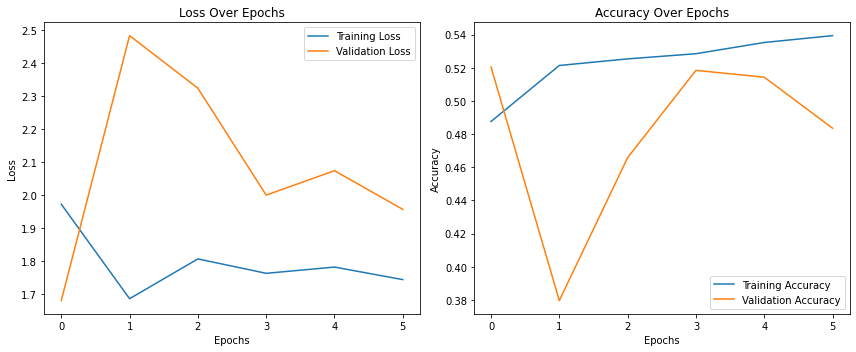

              precision    recall  f1-score   support

       anger       0.59      0.15      0.24       516
     disgust       0.10      0.37      0.16        99
        fear       0.23      0.05      0.08        60
         joy       0.74      0.27      0.39       495
     neutral       0.62      0.80      0.70      1615
     sadness       0.18      0.21      0.20       263
    surprise       0.49      0.42      0.45       352

    accuracy                           0.52      3400
   macro avg       0.42      0.33      0.32      3400
weighted avg       0.56      0.52      0.49      3400



In [24]:
model = RGCNWithGAT(num_features=768, num_classes=7, num_relations=3)

model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_relational_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

show_classification_report_relation_model(model, test_loader)

In [42]:
best_model, best_params = tune_relation_model(RGCNWithGAT, train_loader, val_loader, 768, 7, 3)

show_classification_report_relation_model(best_model, test_loader)

Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 123.81it/s]


Epoch 1: Train Loss = 1.745621972287147, Val Loss = 1.6052377802492293, Train Acc = 0.4983644859813084, Val Acc = 0.5164158686730507


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.24it/s]


Epoch 2: Train Loss = 1.792728475206564, Val Loss = 2.8827925797534624, Train Acc = 0.5180685358255451, Val Acc = 0.41997264021887826


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.11it/s]


Epoch 3: Train Loss = 1.829847601133379, Val Loss = 2.6966961846544613, Train Acc = 0.5324766355140187, Val Acc = 0.533515731874145


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.83it/s]


Epoch 4: Train Loss = 1.787716855853924, Val Loss = 1.9251766641244845, Train Acc = 0.5290498442367602, Val Acc = 0.5095759233926128


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.40it/s]


Epoch 5: Train Loss = 1.8664048543659966, Val Loss = 2.469693665729008, Train Acc = 0.5290498442367602, Val Acc = 0.460328317373461


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.54it/s]


Epoch 6: Train Loss = 1.8469372635748675, Val Loss = 2.212398451294198, Train Acc = 0.5297507788161994, Val Acc = 0.46169630642954856
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:20<00:00, 106.31it/s]


Epoch 1: Train Loss = 100.85045028241315, Val Loss = 111.0241544929481, Train Acc = 0.40101246105919003, Val Acc = 0.4952120383036936


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.08it/s]


Epoch 2: Train Loss = 121.79011489746476, Val Loss = 178.6687594222149, Train Acc = 0.4513239875389408, Val Acc = 0.4952120383036936


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.18it/s]


Epoch 3: Train Loss = 125.07053527495962, Val Loss = 134.962870945299, Train Acc = 0.4665109034267913, Val Acc = 0.466484268125855


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.92it/s]


Epoch 4: Train Loss = 142.31446956010467, Val Loss = 154.41208593613572, Train Acc = 0.4718847352024922, Val Acc = 0.45143638850889195


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 87.91it/s]


Epoch 5: Train Loss = 141.6639763125863, Val Loss = 149.43627167973253, Train Acc = 0.48302180685358254, Val Acc = 0.5177838577291382


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.15it/s]


Epoch 6: Train Loss = 132.9910820863627, Val Loss = 172.2290139081883, Train Acc = 0.4895638629283489, Val Acc = 0.4466484268125855
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 99.73it/s]


Epoch 1: Train Loss = 1.7970089255470367, Val Loss = 2.1450805683102874, Train Acc = 0.4986760124610592, Val Acc = 0.42544459644322846


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.27it/s]


Epoch 2: Train Loss = 1.8490422846931593, Val Loss = 2.1158802205524236, Train Acc = 0.5097352024922118, Val Acc = 0.48221614227086185


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 99.69it/s]


Epoch 3: Train Loss = 1.7826229221918497, Val Loss = 2.0693320762952445, Train Acc = 0.5273364485981309, Val Acc = 0.5471956224350205


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 99.52it/s]


Epoch 4: Train Loss = 1.712382885710445, Val Loss = 2.2254068933323854, Train Acc = 0.5328660436137072, Val Acc = 0.4883720930232558


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.98it/s]


Epoch 5: Train Loss = 1.8462047616030017, Val Loss = 2.1372384115260235, Train Acc = 0.5338785046728972, Val Acc = 0.48768809849521205


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 98.90it/s]


Epoch 6: Train Loss = 1.7497024350162165, Val Loss = 2.332593682479583, Train Acc = 0.5463395638629284, Val Acc = 0.5129958960328317


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.33it/s]


Epoch 7: Train Loss = 1.7180931540352402, Val Loss = 1.9643213345587287, Train Acc = 0.5440031152647975, Val Acc = 0.5157318741450069


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.62it/s]


Epoch 8: Train Loss = 1.7419545116527844, Val Loss = 2.249746937588444, Train Acc = 0.5398753894080996, Val Acc = 0.5205198358413132


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.73it/s]


Epoch 9: Train Loss = 1.7748469314378175, Val Loss = 2.3086401545477133, Train Acc = 0.5517133956386293, Val Acc = 0.47537619699042405


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.48it/s]


Epoch 10: Train Loss = 1.851087612168854, Val Loss = 2.084255166137505, Train Acc = 0.5428348909657321, Val Acc = 0.5341997264021888


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.88it/s]


Epoch 11: Train Loss = 1.7336881022107904, Val Loss = 2.3494178222957998, Train Acc = 0.5478193146417446, Val Acc = 0.4952120383036936


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.47it/s]


Epoch 12: Train Loss = 1.8547941683912847, Val Loss = 2.196780266519636, Train Acc = 0.5461838006230529, Val Acc = 0.5232558139534884
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:18<00:00, 117.24it/s]


Epoch 1: Train Loss = 1.201487454819424, Val Loss = 1.3744065792472273, Train Acc = 0.5876168224299065, Val Acc = 0.533515731874145


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:20<00:00, 104.81it/s]


Epoch 2: Train Loss = 1.095318978865355, Val Loss = 1.3090306689479836, Train Acc = 0.611993769470405, Val Acc = 0.5492476060191519


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:20<00:00, 106.92it/s]


Epoch 3: Train Loss = 1.0608240193325198, Val Loss = 1.308710151358887, Train Acc = 0.6207943925233644, Val Acc = 0.5677154582763337


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:20<00:00, 104.63it/s]


Epoch 4: Train Loss = 1.0236547684219355, Val Loss = 1.383751198594217, Train Acc = 0.6257788161993769, Val Acc = 0.5328317373461012


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 102.50it/s]


Epoch 5: Train Loss = 0.9997013037127477, Val Loss = 1.3810779013015606, Train Acc = 0.6301401869158878, Val Acc = 0.5512995896032832


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:20<00:00, 103.67it/s]


Epoch 6: Train Loss = 0.9743174270938013, Val Loss = 1.3143551587506577, Train Acc = 0.6397196261682243, Val Acc = 0.5738714090287278


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 102.19it/s]


Epoch 7: Train Loss = 0.9570165852192548, Val Loss = 1.3559749554566762, Train Acc = 0.6424454828660436, Val Acc = 0.573187414500684


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 101.44it/s]


Epoch 8: Train Loss = 0.9338977494708228, Val Loss = 1.4922011863716222, Train Acc = 0.642601246105919, Val Acc = 0.5314637482900136


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 101.89it/s]


Epoch 9: Train Loss = 0.913245993070908, Val Loss = 1.3729395290457265, Train Acc = 0.6559968847352025, Val Acc = 0.5560875512995896


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 102.10it/s]


Epoch 10: Train Loss = 0.8902821311888854, Val Loss = 1.409119711200603, Train Acc = 0.6564641744548286, Val Acc = 0.5506155950752394


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.68it/s]


Epoch 11: Train Loss = 0.8767064963646354, Val Loss = 1.400472919418718, Train Acc = 0.6598130841121496, Val Acc = 0.5601915184678523


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 90.00it/s]


Epoch 12: Train Loss = 0.8581710576836485, Val Loss = 1.4222296019757374, Train Acc = 0.6674454828660437, Val Acc = 0.5690834473324213


Epoch 13: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 102.43it/s]


Epoch 13: Train Loss = 0.8389097730631302, Val Loss = 1.4762537369659792, Train Acc = 0.6689252336448598, Val Acc = 0.5560875512995896
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:18<00:00, 117.99it/s]


Epoch 1: Train Loss = 1.1987155286060578, Val Loss = 1.2660013392291687, Train Acc = 0.5870716510903426, Val Acc = 0.5752393980848153


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:20<00:00, 106.09it/s]


Epoch 2: Train Loss = 1.0954890327597107, Val Loss = 1.284361746189771, Train Acc = 0.6185358255451714, Val Acc = 0.5697674418604651


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:20<00:00, 105.30it/s]


Epoch 3: Train Loss = 1.0598234834839348, Val Loss = 1.2977092676692539, Train Acc = 0.6203271028037384, Val Acc = 0.5725034199726402


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 101.67it/s]


Epoch 4: Train Loss = 1.021821534185222, Val Loss = 1.3276005480024549, Train Acc = 0.6286604361370717, Val Acc = 0.554719562243502


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 100.96it/s]


Epoch 5: Train Loss = 0.996983758410163, Val Loss = 1.3712158397805911, Train Acc = 0.6347352024922118, Val Acc = 0.5581395348837209


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.75it/s]


Epoch 6: Train Loss = 0.976318169524462, Val Loss = 1.2996287492483303, Train Acc = 0.6366822429906542, Val Acc = 0.5772913816689467
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}, Best validation accuracy: 0.5772913816689467


TypeError: show_classification_report_relation_model() takes 2 positional arguments but 3 were given

In [43]:
show_classification_report_relation_model(best_model, test_loader)

              precision    recall  f1-score   support

       anger       0.58      0.30      0.40       516
     disgust       0.72      0.13      0.22        99
        fear       0.30      0.13      0.18        60
         joy       0.54      0.43      0.48       495
     neutral       0.68      0.90      0.77      1615
     sadness       0.35      0.17      0.23       263
    surprise       0.45      0.55      0.49       352

    accuracy                           0.61      3400
   macro avg       0.52      0.37      0.40      3400
weighted avg       0.59      0.61      0.58      3400



#### RGAT

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:55<00:00, 12.29it/s]


Epoch 1: Train Loss = 139.17040773500437, Val Loss = 379.73294467042996, Train Acc = 0.28753894080996883, Val Acc = 0.3686730506155951


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:49<00:00, 12.72it/s]


Epoch 2: Train Loss = 368.3503797268904, Val Loss = 180.32993863930065, Train Acc = 0.304595015576324, Val Acc = 0.3276333789329685


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:50<00:00, 12.67it/s]


Epoch 3: Train Loss = 245.034719691346, Val Loss = 177.30354448446298, Train Acc = 0.34003115264797507, Val Acc = 0.4322845417236662


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:50<00:00, 12.69it/s]


Epoch 4: Train Loss = 627.0496462408447, Val Loss = 173.61953657640626, Train Acc = 0.31978193146417444, Val Acc = 0.4630642954856361


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:50<00:00, 12.66it/s]


Epoch 5: Train Loss = 802.6530347234343, Val Loss = 446.3874831996349, Train Acc = 0.3309190031152648, Val Acc = 0.4384404924760602


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:50<00:00, 12.69it/s]


Epoch 6: Train Loss = 657.6204187536817, Val Loss = 359.6327519647915, Train Acc = 0.3467289719626168, Val Acc = 0.4110807113543092


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:50<00:00, 12.67it/s]


Epoch 7: Train Loss = 598.3119055706743, Val Loss = 293.80894066558943, Train Acc = 0.35623052959501555, Val Acc = 0.44596443228454175


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:54<00:00, 12.40it/s]


Epoch 8: Train Loss = 401.59172065416425, Val Loss = 155.41707914339165, Train Acc = 0.3693146417445483, Val Acc = 0.49247606019151846


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:46<00:00, 12.94it/s]


Epoch 9: Train Loss = 333.6440249990865, Val Loss = 132.87349498016684, Train Acc = 0.3852803738317757, Val Acc = 0.34131326949384405


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [02:51<00:00, 12.59it/s]


Epoch 10: Train Loss = 183.07532284451761, Val Loss = 95.74081335112425, Train Acc = 0.4144859813084112, Val Acc = 0.4897400820793434


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [02:50<00:00, 12.68it/s]


Epoch 11: Train Loss = 279.9143656458698, Val Loss = 111.1701074973876, Train Acc = 0.3939252336448598, Val Acc = 0.45075239398084815


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [02:55<00:00, 12.29it/s]


Epoch 12: Train Loss = 539.1519609226569, Val Loss = 310.907427637832, Train Acc = 0.3661993769470405, Val Acc = 0.3850889192886457


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [02:47<00:00, 12.87it/s]


Epoch 13: Train Loss = 250.6637945566461, Val Loss = 145.06595199011542, Train Acc = 0.39922118380062305, Val Acc = 0.4473324213406293


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [02:48<00:00, 12.84it/s]


Epoch 14: Train Loss = 629.0263435783398, Val Loss = 243.59413287904528, Train Acc = 0.37827102803738316, Val Acc = 0.4582763337893297


Epoch 15: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [02:54<00:00, 12.39it/s]


Epoch 15: Train Loss = 292.3405580463827, Val Loss = 139.8851239045461, Train Acc = 0.39633956386292835, Val Acc = 0.5027359781121751
Early stopping triggered


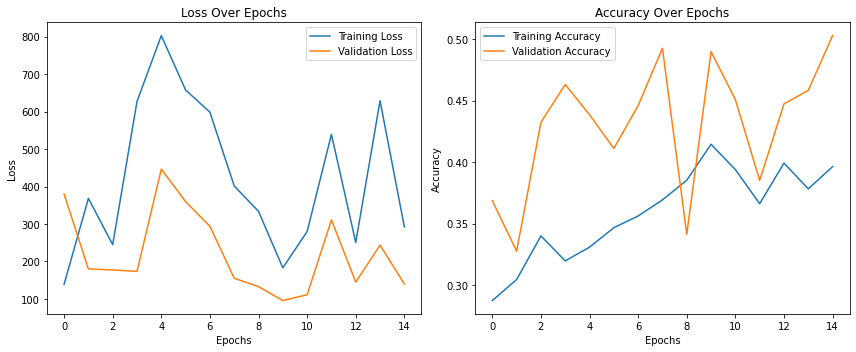

              precision    recall  f1-score   support

       anger       0.38      0.04      0.08       516
     disgust       0.05      0.04      0.04        99
        fear       0.09      0.02      0.03        60
         joy       0.33      0.63      0.44       495
     neutral       0.68      0.82      0.74      1615
     sadness       0.17      0.01      0.01       263
    surprise       0.41      0.39      0.40       352

    accuracy                           0.53      3400
   macro avg       0.30      0.28      0.25      3400
weighted avg       0.49      0.53      0.47      3400



In [28]:
model = RGATWithSkipConnections(num_features=768, num_classes=7, num_relations=3)

model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_relational_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

show_classification_report_relation_model(model, test_loader)

In [44]:
best_model, best_params = tune_relation_model(RGATWithSkipConnections, train_loader, val_loader, 768, 7, 3)

show_classification_report_relation_model(best_model, test_loader)

Training with params: {'lr': 0.1, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 141.66it/s]


Epoch 1: Train Loss = 323.51178437161263, Val Loss = 63.70369568062188, Train Acc = 0.2337227414330218, Val Acc = 0.3372093023255814


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 127.92it/s]


Epoch 2: Train Loss = 194.50992367858873, Val Loss = 217.5659192827013, Train Acc = 0.2728193146417445, Val Acc = 0.19015047879616964


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 125.92it/s]


Epoch 3: Train Loss = 560.7666913342197, Val Loss = 135.98960385984498, Train Acc = 0.2718068535825545, Val Acc = 0.36662106703146374


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 128.67it/s]


Epoch 4: Train Loss = 1093.2833867451452, Val Loss = 222.7452494949999, Train Acc = 0.2295171339563863, Val Acc = 0.32968536251709984


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 126.65it/s]


Epoch 5: Train Loss = 399.8613011094489, Val Loss = 567.0151586144059, Train Acc = 0.2688473520249221, Val Acc = 0.09370725034199727


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 131.55it/s]


Epoch 6: Train Loss = 617.7771323904188, Val Loss = 264.8482909650713, Train Acc = 0.26557632398753894, Val Acc = 0.4015047879616963
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 124.83it/s]


Epoch 1: Train Loss = 1.858695792662911, Val Loss = 1.6157349301157173, Train Acc = 0.4092679127725857, Val Acc = 0.45348837209302323


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 126.11it/s]


Epoch 2: Train Loss = 1.9034145783632994, Val Loss = 1.748025692668226, Train Acc = 0.4147196261682243, Val Acc = 0.45554035567715456


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 124.73it/s]


Epoch 3: Train Loss = 2.3855471039302993, Val Loss = 1.7649705203870931, Train Acc = 0.38333333333333336, Val Acc = 0.4418604651162791


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 128.49it/s]


Epoch 4: Train Loss = 2.1308962248709844, Val Loss = 1.8657012672336013, Train Acc = 0.3990654205607477, Val Acc = 0.2948016415868673


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 127.66it/s]


Epoch 5: Train Loss = 1.961158073974204, Val Loss = 2.0640135482505517, Train Acc = 0.41970404984423676, Val Acc = 0.42476060191518467


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 130.89it/s]


Epoch 6: Train Loss = 1.79309983133582, Val Loss = 1.4377149252910857, Train Acc = 0.4501557632398754, Val Acc = 0.47058823529411764


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 128.02it/s]


Epoch 7: Train Loss = 2.0365598943146996, Val Loss = 1.9348744697661864, Train Acc = 0.41425233644859816, Val Acc = 0.4637482900136799


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 131.31it/s]


Epoch 8: Train Loss = 1.7217443700189943, Val Loss = 1.6186069170082058, Train Acc = 0.4657320872274143, Val Acc = 0.4630642954856361


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 129.44it/s]


Epoch 9: Train Loss = 1.7194941738472724, Val Loss = 1.5494715993051176, Train Acc = 0.4654205607476635, Val Acc = 0.460328317373461


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 129.44it/s]


Epoch 10: Train Loss = 1.555343651474902, Val Loss = 1.47689242478874, Train Acc = 0.4863707165109034, Val Acc = 0.5


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 129.83it/s]


Epoch 11: Train Loss = 1.8588753473760369, Val Loss = 1.50543056184219, Train Acc = 0.46970404984423675, Val Acc = 0.5102599179206566
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 30, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 131.15it/s]


Epoch 1: Train Loss = 671.3113791720396, Val Loss = 127.29733092784882, Train Acc = 0.2192367601246106, Val Acc = 0.4021887824897401


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 133.25it/s]


Epoch 2: Train Loss = 972.1739807871631, Val Loss = 303.9603985529091, Train Acc = 0.2411993769470405, Val Acc = 0.3173734610123119


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 131.02it/s]


Epoch 3: Train Loss = 977.7813744090679, Val Loss = 243.4103974751714, Train Acc = 0.24244548286604362, Val Acc = 0.32558139534883723


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 135.11it/s]


Epoch 4: Train Loss = 962.1025031314846, Val Loss = 204.63325644796413, Train Acc = 0.2525700934579439, Val Acc = 0.39466484268125857


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 128.85it/s]


Epoch 5: Train Loss = 1127.9812176178614, Val Loss = 396.18682674464566, Train Acc = 0.2597352024922118, Val Acc = 0.3755129958960328


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 129.19it/s]


Epoch 6: Train Loss = 579.4101976598681, Val Loss = 212.93049125428553, Train Acc = 0.28006230529595016, Val Acc = 0.3953488372093023


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 129.44it/s]


Epoch 7: Train Loss = 475.1085242274784, Val Loss = 1518.1870412332041, Train Acc = 0.3013239875389408, Val Acc = 0.40355677154582764


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 134.29it/s]


Epoch 8: Train Loss = 578.4702934287105, Val Loss = 209.83618582177442, Train Acc = 0.2751557632398754, Val Acc = 0.3036935704514364


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 131.55it/s]


Epoch 9: Train Loss = 271.3570739459627, Val Loss = 140.81175003066477, Train Acc = 0.3222741433021807, Val Acc = 0.3912448700410397


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 134.84it/s]


Epoch 10: Train Loss = 439.076734032083, Val Loss = 209.84680983633908, Train Acc = 0.30638629283489094, Val Acc = 0.3344733242134063


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 131.28it/s]


Epoch 11: Train Loss = 488.47735845147423, Val Loss = 1119.3583522410702, Train Acc = 0.2900311526479751, Val Acc = 0.2920656634746922
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 135.54it/s]


Epoch 1: Train Loss = 1.3341673197017776, Val Loss = 1.3487196789295586, Train Acc = 0.5378504672897196, Val Acc = 0.5328317373461012


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 132.21it/s]


Epoch 2: Train Loss = 1.1798158414765365, Val Loss = 1.3113864403631952, Train Acc = 0.5857476635514018, Val Acc = 0.5478796169630643


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:15<00:00, 135.25it/s]


Epoch 3: Train Loss = 1.136383425961766, Val Loss = 1.2818326699237028, Train Acc = 0.602803738317757, Val Acc = 0.5574555403556771


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 131.65it/s]


Epoch 4: Train Loss = 1.1156983153722078, Val Loss = 1.2921649673470745, Train Acc = 0.6082554517133957, Val Acc = 0.5615595075239398


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 134.13it/s]


Epoch 5: Train Loss = 1.1001358164793433, Val Loss = 1.2894870469691577, Train Acc = 0.6151090342679127, Val Acc = 0.5601915184678523


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 130.89it/s]


Epoch 6: Train Loss = 1.0793798989392127, Val Loss = 1.2951856228488463, Train Acc = 0.6216510903426792, Val Acc = 0.5629274965800274


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 133.65it/s]


Epoch 7: Train Loss = 1.0655420925813142, Val Loss = 1.3321004080551642, Train Acc = 0.6218847352024922, Val Acc = 0.5540355677154583


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 132.18it/s]


Epoch 8: Train Loss = 1.0554850711927024, Val Loss = 1.3049075302978357, Train Acc = 0.6227414330218068, Val Acc = 0.5718194254445964
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 126.93it/s]


Epoch 1: Train Loss = 1.6829953389707952, Val Loss = 1.7550855070214582, Train Acc = 0.4404984423676013, Val Acc = 0.43433652530779754


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 125.44it/s]


Epoch 2: Train Loss = 2.2599588929321963, Val Loss = 1.8020927882856792, Train Acc = 0.4000778816199377, Val Acc = 0.4158686730506156


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 126.29it/s]


Epoch 3: Train Loss = 2.370092276185406, Val Loss = 1.6358109407678798, Train Acc = 0.3689252336448598, Val Acc = 0.47537619699042405


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 129.16it/s]


Epoch 4: Train Loss = 1.9417282093611667, Val Loss = 1.75041171544128, Train Acc = 0.42281931464174455, Val Acc = 0.4528043775649795


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 121.42it/s]


Epoch 5: Train Loss = 2.927174757309452, Val Loss = 1.7725395702101565, Train Acc = 0.35397196261682246, Val Acc = 0.41381668946648426


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 125.50it/s]


Epoch 6: Train Loss = 2.642545370301943, Val Loss = 1.8509413526152019, Train Acc = 0.36721183800623053, Val Acc = 0.44528043775649795


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 125.55it/s]


Epoch 7: Train Loss = 2.1810653472888175, Val Loss = 1.8987857858339945, Train Acc = 0.4029595015576324, Val Acc = 0.42339261285909713


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 125.07it/s]


Epoch 8: Train Loss = 2.162154230607363, Val Loss = 1.8702904342501252, Train Acc = 0.3959501557632399, Val Acc = 0.32694938440492477
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}, Best validation accuracy: 0.5718194254445964
              precision    recall  f1-score   support

       anger       0.48      0.29      0.36       516
     disgust       0.33      0.01      0.02        99
        fear       0.00      0.00      0.00        60
         joy       0.47      0.50      0.49       495
     neutral       0.68      0.90      0.77      1615
     sadness       0.14      0.00      0.01       263
    surprise       0.45      0.52      0.48       352

    accuracy                           0.60      3400
   macro avg       0.36      0.32      0.30      3400
weighted avg       0.53      0.60      0.54      3400



C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

#### EdgeGAT

In [29]:
DIOLOG_ID = 0
startIdx, endIdx = rangesTrain[DIOLOG_ID][0], rangesTrain[DIOLOG_ID][1]

graph = dgl.graph((edgeIndicesTrain[DIOLOG_ID][0], edgeIndicesTrain[DIOLOG_ID][1]))
edge_feats = get_ohe(edgeTypesTrain[DIOLOG_ID])

# egat_output = egat(graph, contextualEmbeddings[startIdx: endIdx+1], edge_feats)

In [ ]:
graph

In [64]:
class EGATConv(nn.Module):
    def __init__(self,
                 in_node_feats,
                 in_edge_feats,
                 out_node_feats,
                 out_edge_feats,
                 num_heads,
                 bias=True,
                 **kw_args):

        super().__init__()
        self._num_heads = num_heads
        self._out_node_feats = out_node_feats
        self._out_edge_feats = out_edge_feats
        
        self.fc_node = nn.Linear(in_node_feats, out_node_feats * num_heads, bias=bias)
        self.fc_ni = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        self.fc_fij = nn.Linear(in_edge_feats, out_edge_feats * num_heads, bias=False)
        self.fc_nj = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        
        # Attention parameter
        self.attn = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_edge_feats)))
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(size=(num_heads * out_edge_feats,)))
        else:
            self.register_buffer('bias', None)
        
        self.reset_parameters()

    def reset_parameters(self):
        torch.manual_seed(42)
        gain = init.calculate_gain('relu')
        init.xavier_normal_(self.fc_node.weight, gain=gain)
        init.xavier_normal_(self.fc_ni.weight, gain=gain)
        init.xavier_normal_(self.fc_fij.weight, gain=gain)
        init.xavier_normal_(self.fc_nj.weight, gain=gain)
        init.xavier_normal_(self.attn, gain=gain)
        
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)

    def forward(self, graph, nfeats, efeats, get_attention=False):
        with graph.local_scope():
            graph.edata['f'] = efeats
            graph.ndata['h'] = nfeats
            
            f_ni = self.fc_ni(nfeats)
            f_nj = self.fc_nj(nfeats)
            f_fij = self.fc_fij(efeats)
            graph.srcdata.update({'f_ni' : f_ni})
            graph.dstdata.update({'f_nj' : f_nj})
            
            graph.apply_edges(fn.u_add_v('f_ni', 'f_nj', 'f_tmp'))
            f_out = graph.edata.pop('f_tmp') + f_fij
            
            if self.bias is not None:
                f_out += self.bias
            f_out = nn.functional.leaky_relu(f_out)
            f_out = f_out.view(-1, self._num_heads, self._out_edge_feats)
            
            e = (f_out * self.attn).sum(dim=-1).unsqueeze(-1)
            graph.edata['a'] = edge_softmax(graph, e)
            graph.ndata['h_out'] = self.fc_node(nfeats).view(-1, self._num_heads, self._out_node_feats)
            
            graph.update_all(fn.u_mul_e('h_out', 'a', 'm'), fn.sum('m', 'h_out'))

            h_out = graph.ndata['h_out'].view(-1, self._num_heads, self._out_node_feats)
            if get_attention:
                return h_out, f_out, graph.edata.pop('a')
            else:
                return h_out, f_out
            
class EdgeGATWithSkipConnection(nn.Module):
    def __init__(self, in_node_feats, in_edge_feats=3, out_node_feats=64, out_edge_feats=3, num_heads=4, num_classes=7):
        super(EdgeGATWithSkipConnection, self).__init__()
        self.egat1 = EGATConv(in_node_feats, in_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.egat2 = EGATConv(out_node_feats, out_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.skip_transformation = nn.Linear(in_node_feats, out_node_feats)
        self.fc = nn.Linear(out_node_feats, num_classes)

    def forward(self, graph, nfeats, efeats):
        # Add self-loops to edge_index and adjust edge_attr accordingly if needed
#         print(f"nfeats shape: {nfeats.shape}")
        x_skip = self.skip_transformation(nfeats)  # Transform the input for the skip connection
        x, e = self.egat1(graph, nfeats, efeats)
        x = x.max(dim=1).values  # Aggregate over heads
        x = F.relu(x)
#         print(f"X shape: {x.shape}")
        x, e = self.egat2(graph, x, efeats)  # Ensure x is reshaped properly
        x = x.max(dim=1).values  # Aggregate over heads
#         print(x.shape, " vs ", x_skip.shape)
        x += x_skip  # Add skip connection
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
class EdgeGATWithGCN(nn.Module):
    def __init__(self, in_node_feats, in_edge_feats=3, out_node_feats=64, out_edge_feats=3, num_heads=4, num_classes=7):
        super(EdgeGATWithGCN, self).__init__()
        self.egat1 = EGATConv(in_node_feats, in_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.egat2 = EGATConv(out_node_feats, out_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.gcn = GCNConv(out_node_feats, out_node_feats)  # GCN layer
        self.skip_transformation = nn.Linear(in_node_feats, out_node_feats)
        self.fc = nn.Linear(out_node_feats, num_classes)

    def forward(self, graph, nfeats, efeats):
        data = self.convert_to_pyg_data(graph, nfeats, efeats)

        x_skip = self.skip_transformation(nfeats)  # Transform the input for the skip connection
        x, e = self.egat1(graph, nfeats, efeats)
        x = x.max(dim=1).values  # Aggregate over heads
        x = F.relu(x)
        
#         # EGAT layer 2
#         x, e = self.egat2(graph, x, e)
#         x = F.relu(x)

        # Skip connection

        # GCN layer
        x = self.gcn(x, data.edge_index)
        x += x_skip
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def convert_to_pyg_data(self, graph, nfeats, efeats):
        # Extract features from DGL graph
        x = nfeats  # Node features

        # Extract edge indices
        src, dst = graph.edges()
        edge_index = torch.stack([src, dst], dim=0).long()

        # Assuming edge features are in the form suitable for PyTorch Geometric
        edge_attr = efeats

        # Create PyTorch Geometric Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        data.num_nodes = graph.number_of_nodes()  # Set number of nodes
        data.batch = torch.zeros(x.size(0), dtype=torch.long)  # Dummy batch attribute

        return data
    
class Edge2GATWithGCN(nn.Module):
    def __init__(self, in_node_feats, in_edge_feats=3, out_node_feats=64, out_edge_feats=3, num_heads=4, num_classes=7):
        super(Edge2GATWithGCN, self).__init__()
        self.egat1 = EGATConv(in_node_feats, in_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.egat2 = EGATConv(out_node_feats, out_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.gcn = GCNConv(out_node_feats, out_node_feats)  # GCN layer
        self.skip_transformation = nn.Linear(in_node_feats, out_node_feats)
        self.fc = nn.Linear(out_node_feats, num_classes)

    def forward(self, graph, nfeats, efeats):
        data = self.convert_to_pyg_data(graph, nfeats, efeats)

        x_skip = self.skip_transformation(nfeats)  # Transform the input for the skip connection
        x, e = self.egat1(graph, nfeats, efeats)
        x = x.max(dim=1).values  # Aggregate over heads
        x = F.relu(x)
        x, e = self.egat2(graph, x, efeats)  # Ensure x is reshaped properly
        x = x.max(dim=1).values  # Aggregate over heads
        x = F.relu(x)

        # Skip connection

        # GCN layer
        x = self.gcn(x, data.edge_index)
        x += x_skip
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def convert_to_pyg_data(self, graph, nfeats, efeats):
        # Extract features from DGL graph
        x = nfeats  # Node features

        # Extract edge indices
        src, dst = graph.edges()
        edge_index = torch.stack([src, dst], dim=0).long()

        # Assuming edge features are in the form suitable for PyTorch Geometric
        edge_attr = efeats

        # Create PyTorch Geometric Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        data.num_nodes = graph.number_of_nodes()  # Set number of nodes
        data.batch = torch.zeros(x.size(0), dtype=torch.long)  # Dummy batch attribute

        return data

In [52]:
def train_egat_model(model, train_loader, val_loader, lr=0.01, num_epochs=25, early_stop_threshold=0.0001, max_no_improve_epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0


        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            graph = dgl.graph((data.edge_index[0], data.edge_index[1]))
            edge_feats = get_ohe(data.edge_type)
            out = model(graph, data.x, edge_feats)

            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = out.argmax(dim=1)
            correct_train += (preds == data.y).sum().item()
            total_train += data.y.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data in val_loader:
                graph = dgl.graph((data.edge_index[0], data.edge_index[1]))
                edge_feats = get_ohe(data.edge_type)
                out = model(graph, data.x , edge_feats)
                loss = criterion(out, data.y)
                val_loss += loss.item()

                preds = out.argmax(dim=1)
                correct_val += (preds == data.y).sum().item()
                total_val += data.y.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")

        if best_val_loss - val_losses[-1] < early_stop_threshold:
            no_improve_epochs += 1
            if no_improve_epochs >= max_no_improve_epochs:
                print("Early stopping triggered")
                break
        else:
            no_improve_epochs = 0
            best_val_loss = val_losses[-1]
            
    return model, train_losses, val_losses, train_accuracies, val_accuracies

def tune_egat_model(model_class, train_loader, val_loader, num_features, num_classes, num_relations):
    # Define hyperparameter space
    param_space = {
        'lr': [0.001, 0.01, 0.1],
        'num_epochs': [20, 25, 30],
        'early_stop_threshold': [0.0001, 0.0005, 0.001],
        'max_no_improve_epochs': [5, 10]
    }

    # Generate up to 5 random hyperparameter combinations
    param_combinations = [
        {
            'lr': random.choice(param_space['lr']),
            'num_epochs': random.choice(param_space['num_epochs']),
            'early_stop_threshold': random.choice(param_space['early_stop_threshold']),
            'max_no_improve_epochs': random.choice(param_space['max_no_improve_epochs'])
        }
        for _ in range(5)
    ]

    best_val_acc = 0
    best_params = None
    best_model = None

    for params in param_combinations:
        print(f"Training with params: {params}")
        model = model_class(num_features, num_classes, num_relations)
        model, _, _, _, val_accuracies = train_egat_model(
            model,
            train_loader,
            val_loader,
            lr=params['lr'],
            num_epochs=params['num_epochs'],
            early_stop_threshold=params['early_stop_threshold'],
            max_no_improve_epochs=params['max_no_improve_epochs']
        )

        val_acc = max(val_accuracies)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params
            best_model = model

    print(f"Best params: {best_params}, Best validation accuracy: {best_val_acc}")
    return best_model, best_params

def show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()
    
def show_classification_report_egat_model(model, test_loader):
    # Classification report on test set
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            graph = dgl.graph((data.edge_index[0], data.edge_index[1]))
            edge_feats = get_ohe(data.edge_type)
            out = model(graph, data.x , edge_feats)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=label_decoder.values()))

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:37<00:00, 58.16it/s]


Epoch 1: Train Loss = 1.7254148191398364, Val Loss = 2.416238339146905, Train Acc = 0.4942367601246106, Val Acc = 0.48700410396716826


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:39<00:00, 54.81it/s]


Epoch 2: Train Loss = 1.8723803112598079, Val Loss = 2.012545113734625, Train Acc = 0.5167445482866043, Val Acc = 0.5027359781121751


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:41<00:00, 52.56it/s]


Epoch 3: Train Loss = 1.7422776122416204, Val Loss = 1.8845896742789559, Train Acc = 0.5242211838006231, Val Acc = 0.5150478796169631


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:40<00:00, 52.80it/s]


Epoch 4: Train Loss = 1.7730759619755123, Val Loss = 2.7901316105767533, Train Acc = 0.5349688473520249, Val Acc = 0.32421340629274964


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:41<00:00, 52.25it/s]


Epoch 5: Train Loss = 1.76985118201689, Val Loss = 1.793151555935684, Train Acc = 0.5276479750778816, Val Acc = 0.5362517099863201


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:40<00:00, 53.01it/s]


Epoch 6: Train Loss = 1.964114242975518, Val Loss = 2.0017981528270026, Train Acc = 0.5317757009345795, Val Acc = 0.4945280437756498


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:40<00:00, 52.89it/s]


Epoch 7: Train Loss = 1.7881077363942517, Val Loss = 2.6694198403458964, Train Acc = 0.5455607476635514, Val Acc = 0.5109439124487004


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:41<00:00, 52.57it/s]


Epoch 8: Train Loss = 1.7416741698396099, Val Loss = 2.5161493284653664, Train Acc = 0.5460280373831776, Val Acc = 0.4582763337893297


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:41<00:00, 52.42it/s]


Epoch 9: Train Loss = 1.826680609283816, Val Loss = 2.304063403647807, Train Acc = 0.5420560747663551, Val Acc = 0.4582763337893297


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:41<00:00, 52.40it/s]


Epoch 10: Train Loss = 1.8342333617800233, Val Loss = 2.32207018112186, Train Acc = 0.5483644859813084, Val Acc = 0.5013679890560876
Early stopping triggered


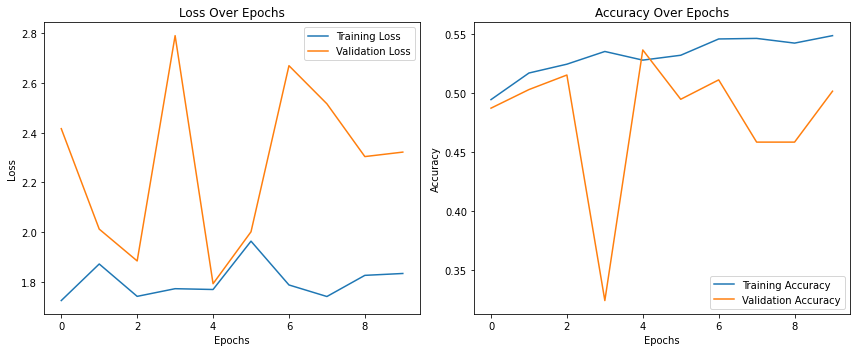

              precision    recall  f1-score   support

       anger       0.54      0.18      0.27       516
     disgust       0.64      0.18      0.28        99
        fear       0.00      0.00      0.00        60
         joy       0.34      0.69      0.46       495
     neutral       0.73      0.72      0.72      1615
     sadness       0.31      0.28      0.30       263
    surprise       0.48      0.52      0.50       352

    accuracy                           0.55      3400
   macro avg       0.44      0.37      0.36      3400
weighted avg       0.57      0.55      0.53      3400



In [32]:
model = EdgeGATWithSkipConnection(in_node_feats=768, out_node_feats=64, out_edge_feats=3, num_heads=4)
# model = EdgeGATWithGCN(in_node_feats=768, out_node_feats=64, out_edge_feats=3, num_heads=4)
model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_egat_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

show_classification_report_egat_model(model, test_loader)

In [56]:
best_model, best_params = tune_egat_model(EdgeGATWithSkipConnection, train_loader, val_loader, 768, 3, 4)

Training with params: {'lr': 0.1, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 74.28it/s]


Epoch 1: Train Loss = 4.683117215458024, Val Loss = 6.872076931237933, Train Acc = 0.364797507788162, Val Acc = 0.17305061559507523


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.49it/s]


Epoch 2: Train Loss = 8.417251908572782, Val Loss = 2.928294611639447, Train Acc = 0.40498442367601245, Val Acc = 0.3119015047879617


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.71it/s]


Epoch 3: Train Loss = 4.3354363635499, Val Loss = 6.920344348951444, Train Acc = 0.3967289719626168, Val Acc = 0.38645690834473323


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.64it/s]


Epoch 4: Train Loss = 5.043658674249408, Val Loss = 3.9973459019450712, Train Acc = 0.3885514018691589, Val Acc = 0.44459644322845415


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.91it/s]


Epoch 5: Train Loss = 4.916745704006287, Val Loss = 4.237351143208367, Train Acc = 0.3779595015576324, Val Acc = 0.393296853625171


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.31it/s]


Epoch 6: Train Loss = 5.251653656413344, Val Loss = 3.193690031617505, Train Acc = 0.3989096573208723, Val Acc = 0.43091655266757867


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 61.74it/s]


Epoch 7: Train Loss = 4.650987697635829, Val Loss = 11.654502242362058, Train Acc = 0.3915109034267913, Val Acc = 0.18946648426812585
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 70.45it/s]


Epoch 1: Train Loss = 6.286686184198467, Val Loss = 2.699043585004768, Train Acc = 0.3810747663551402, Val Acc = 0.4473324213406293


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.15it/s]


Epoch 2: Train Loss = 6.327554426208737, Val Loss = 3.0783354476094247, Train Acc = 0.4164330218068536, Val Acc = 0.2414500683994528


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 67.56it/s]


Epoch 3: Train Loss = 4.471806508132516, Val Loss = 4.284858021995536, Train Acc = 0.38434579439252337, Val Acc = 0.3173734610123119


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 67.77it/s]


Epoch 4: Train Loss = 5.433883522294671, Val Loss = 5.184905975149229, Train Acc = 0.3925233644859813, Val Acc = 0.4172366621067031


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 67.61it/s]


Epoch 5: Train Loss = 4.696313468067967, Val Loss = 3.5946377451117666, Train Acc = 0.3959501557632399, Val Acc = 0.38372093023255816


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 67.18it/s]


Epoch 6: Train Loss = 4.278244372732304, Val Loss = 3.303453340208917, Train Acc = 0.3915109034267913, Val Acc = 0.36730506155950754
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.89it/s]


Epoch 1: Train Loss = 1.2730222398846376, Val Loss = 1.3919116382245664, Train Acc = 0.5695482866043614, Val Acc = 0.5129958960328317


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.23it/s]


Epoch 2: Train Loss = 1.185548977840571, Val Loss = 1.436262515463211, Train Acc = 0.5936915887850467, Val Acc = 0.5554035567715458


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.83it/s]


Epoch 3: Train Loss = 1.1586002107192246, Val Loss = 1.4233715987867779, Train Acc = 0.5966510903426792, Val Acc = 0.49794801641586867


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.65it/s]


Epoch 4: Train Loss = 1.1245839628028786, Val Loss = 1.3454070461017114, Train Acc = 0.6039719626168224, Val Acc = 0.5533515731874145


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 67.71it/s]


Epoch 5: Train Loss = 1.114891053505104, Val Loss = 1.4616500194012014, Train Acc = 0.6071651090342679, Val Acc = 0.5403556771545828


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 67.10it/s]


Epoch 6: Train Loss = 1.1154366625317682, Val Loss = 1.459009327656693, Train Acc = 0.6092679127725856, Val Acc = 0.5554035567715458


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.77it/s]


Epoch 7: Train Loss = 1.1003511410874867, Val Loss = 1.3642176632389977, Train Acc = 0.6086448598130841, Val Acc = 0.5629274965800274


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 67.28it/s]


Epoch 8: Train Loss = 1.090698330183147, Val Loss = 1.518766466645455, Train Acc = 0.608411214953271, Val Acc = 0.5437756497948016


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 67.19it/s]


Epoch 9: Train Loss = 1.0814494644817725, Val Loss = 1.4814864586555847, Train Acc = 0.6140186915887851, Val Acc = 0.5294117647058824


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 67.35it/s]


Epoch 10: Train Loss = 1.0728711109073763, Val Loss = 1.5498678169799625, Train Acc = 0.6136292834890966, Val Acc = 0.5287277701778386


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.62it/s]


Epoch 11: Train Loss = 1.0690623399167736, Val Loss = 1.563299681439444, Train Acc = 0.6138629283489097, Val Acc = 0.4774281805745554


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 67.17it/s]


Epoch 12: Train Loss = 1.0541814781350292, Val Loss = 1.39440621463237, Train Acc = 0.6172897196261682, Val Acc = 0.5403556771545828


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 67.10it/s]


Epoch 13: Train Loss = 1.0536495111270427, Val Loss = 1.3739681493628908, Train Acc = 0.6192367601246106, Val Acc = 0.5471956224350205


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 65.26it/s]


Epoch 14: Train Loss = 1.046378002460632, Val Loss = 1.434920400115489, Train Acc = 0.6205607476635514, Val Acc = 0.5321477428180574
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:28<00:00, 76.27it/s]


Epoch 1: Train Loss = 1.2851549815843573, Val Loss = 1.3890917494893074, Train Acc = 0.5678348909657321, Val Acc = 0.5170998632010944


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:28<00:00, 74.75it/s]


Epoch 2: Train Loss = 1.1972601699642837, Val Loss = 1.4111040321765123, Train Acc = 0.5919003115264797, Val Acc = 0.5588235294117647


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:28<00:00, 75.13it/s]


Epoch 3: Train Loss = 1.163269593001395, Val Loss = 1.3801558443517596, Train Acc = 0.5950934579439252, Val Acc = 0.5157318741450069


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 73.09it/s]


Epoch 4: Train Loss = 1.1303445020681937, Val Loss = 1.348321411855243, Train Acc = 0.6041277258566978, Val Acc = 0.5554035567715458


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 73.21it/s]


Epoch 5: Train Loss = 1.116277771105093, Val Loss = 1.4711881384667422, Train Acc = 0.6067757009345794, Val Acc = 0.5362517099863201


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.96it/s]


Epoch 6: Train Loss = 1.1165734487995334, Val Loss = 1.4585859237721672, Train Acc = 0.6097352024922118, Val Acc = 0.5533515731874145


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 73.09it/s]


Epoch 7: Train Loss = 1.102570777602442, Val Loss = 1.3817406300593305, Train Acc = 0.6105140186915888, Val Acc = 0.5677154582763337


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 72.90it/s]


Epoch 8: Train Loss = 1.093231471625795, Val Loss = 1.5218257989665425, Train Acc = 0.6065420560747663, Val Acc = 0.5389876880984952


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 72.53it/s]


Epoch 9: Train Loss = 1.0830080868909135, Val Loss = 1.464798630953387, Train Acc = 0.6137071651090342, Val Acc = 0.5177838577291382


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.96it/s]


Epoch 10: Train Loss = 1.0742129101062245, Val Loss = 1.5642285852417075, Train Acc = 0.6117601246105919, Val Acc = 0.5273597811217511


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 72.31it/s]


Epoch 11: Train Loss = 1.0689864043133437, Val Loss = 1.5825795218348504, Train Acc = 0.6137071651090342, Val Acc = 0.47058823529411764


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.09it/s]


Epoch 12: Train Loss = 1.0554446302115037, Val Loss = 1.3905429184712745, Train Acc = 0.6169003115264797, Val Acc = 0.5376196990424077


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.87it/s]


Epoch 13: Train Loss = 1.0552959050956243, Val Loss = 1.3769746465263544, Train Acc = 0.6187694704049844, Val Acc = 0.5430916552667578


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.43it/s]


Epoch 14: Train Loss = 1.0475121987686078, Val Loss = 1.430978946863777, Train Acc = 0.620404984423676, Val Acc = 0.5417236662106704
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 79.82it/s]


Epoch 1: Train Loss = 1.2580103196376176, Val Loss = 1.2992482659993347, Train Acc = 0.5658878504672897, Val Acc = 0.5601915184678523


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:28<00:00, 77.04it/s]


Epoch 2: Train Loss = 1.1193531127025684, Val Loss = 1.2893769697182709, Train Acc = 0.6115264797507788, Val Acc = 0.5581395348837209


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 77.52it/s]


Epoch 3: Train Loss = 1.075679181024639, Val Loss = 1.2755062827633488, Train Acc = 0.6234423676012462, Val Acc = 0.5683994528043775


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 77.15it/s]


Epoch 4: Train Loss = 1.043640440778324, Val Loss = 1.3132916383997157, Train Acc = 0.632398753894081, Val Acc = 0.5642954856361149


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [03:23<00:00, 10.64it/s]


Epoch 5: Train Loss = 1.023482747421669, Val Loss = 1.318003446498403, Train Acc = 0.6361370716510903, Val Acc = 0.5718194254445964


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 73.50it/s]


Epoch 6: Train Loss = 1.0095857899170368, Val Loss = 1.3056556146591902, Train Acc = 0.6362928348909658, Val Acc = 0.5752393980848153


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 70.23it/s]


Epoch 7: Train Loss = 0.989868957470861, Val Loss = 1.3750062765139672, Train Acc = 0.6453271028037383, Val Acc = 0.56703146374829


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.40it/s]


Epoch 8: Train Loss = 0.9803113403277368, Val Loss = 1.308461607247591, Train Acc = 0.6440031152647975, Val Acc = 0.5704514363885089


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.31it/s]


Epoch 9: Train Loss = 0.9669543556183473, Val Loss = 1.3116778945343361, Train Acc = 0.6472741433021807, Val Acc = 0.5649794801641587


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.78it/s]


Epoch 10: Train Loss = 0.9553850000287639, Val Loss = 1.3032177318715388, Train Acc = 0.6496105919003116, Val Acc = 0.5649794801641587


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 70.31it/s]


Epoch 11: Train Loss = 0.9446839236786926, Val Loss = 1.3367075852359886, Train Acc = 0.6525700934579439, Val Acc = 0.551983584131327


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 72.57it/s]


Epoch 12: Train Loss = 0.9282389880265799, Val Loss = 1.333112497696722, Train Acc = 0.6580996884735203, Val Acc = 0.56703146374829


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.31it/s]


Epoch 13: Train Loss = 0.9184822827326705, Val Loss = 1.3146446107024397, Train Acc = 0.6603582554517134, Val Acc = 0.5629274965800274
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}, Best validation accuracy: 0.5752393980848153


RuntimeError: mat1 and mat2 must have the same dtype, but got Long and Float

In [59]:
show_classification_report_egat_model(best_model, test_loader)

              precision    recall  f1-score   support

       anger       0.51      0.36      0.42       516
     disgust       0.33      0.01      0.02        99
        fear       0.00      0.00      0.00        60
         joy       0.43      0.55      0.48       495
     neutral       0.71      0.81      0.76      1615
     sadness       0.32      0.19      0.24       263
    surprise       0.47      0.53      0.50       352

    accuracy                           0.59      3400
   macro avg       0.40      0.35      0.35      3400
weighted avg       0.56      0.59      0.56      3400



C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [71]:
best_model, best_params = tune_egat_model(EdgeGATWithGCN, train_loader, val_loader, 768, 3, 4)
show_classification_report_egat_model(best_model, test_loader)

Training with params: {'lr': 0.01, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 86.73it/s]


Epoch 1: Train Loss = 1.2852491735463478, Val Loss = 1.4623318971307189, Train Acc = 0.5611370716510904, Val Acc = 0.5280437756497948


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 79.10it/s]


Epoch 2: Train Loss = 1.1943415127168582, Val Loss = 1.3887126417140718, Train Acc = 0.5915109034267912, Val Acc = 0.560875512995896


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 82.81it/s]


Epoch 3: Train Loss = 1.1625481518946967, Val Loss = 1.3315664764493704, Train Acc = 0.5956386292834891, Val Acc = 0.5704514363885089


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:28<00:00, 76.99it/s]


Epoch 4: Train Loss = 1.1380844902661111, Val Loss = 1.5157056296451223, Train Acc = 0.5968847352024922, Val Acc = 0.5362517099863201


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 80.42it/s]


Epoch 5: Train Loss = 1.1238421383934716, Val Loss = 1.4563523674866667, Train Acc = 0.6031152647975078, Val Acc = 0.5266757865937073


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 80.49it/s]


Epoch 6: Train Loss = 1.1117567013483494, Val Loss = 1.519347208034661, Train Acc = 0.6040498442367601, Val Acc = 0.5389876880984952


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 78.78it/s]


Epoch 7: Train Loss = 1.1016115941745401, Val Loss = 1.5697875150375895, Train Acc = 0.6095794392523365, Val Acc = 0.478796169630643


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 81.44it/s]


Epoch 8: Train Loss = 1.084921332093223, Val Loss = 1.351341240880666, Train Acc = 0.6124610591900311, Val Acc = 0.5403556771545828


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 87.50it/s]


Epoch 9: Train Loss = 1.0799922783703855, Val Loss = 1.3751927367239087, Train Acc = 0.6115264797507788, Val Acc = 0.5458276333789329


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 83.12it/s]


Epoch 10: Train Loss = 1.0704798661642363, Val Loss = 1.407486685230914, Train Acc = 0.6177570093457944, Val Acc = 0.5444596443228454


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 84.61it/s]


Epoch 11: Train Loss = 1.0712784681742993, Val Loss = 1.3730867010713728, Train Acc = 0.6121495327102804, Val Acc = 0.5492476060191519


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 85.17it/s]


Epoch 12: Train Loss = 1.0587594146107289, Val Loss = 1.3845606090018043, Train Acc = 0.6160436137071651, Val Acc = 0.5273597811217511


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 84.72it/s]


Epoch 13: Train Loss = 1.0422105855110135, Val Loss = 1.4056959051500868, Train Acc = 0.6213395638629283, Val Acc = 0.5444596443228454
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.32it/s]


Epoch 1: Train Loss = 1.2820568489341961, Val Loss = 1.3547776609383249, Train Acc = 0.563006230529595, Val Acc = 0.5540355677154583


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 87.12it/s]


Epoch 2: Train Loss = 1.1954620048843532, Val Loss = 1.3876293366636943, Train Acc = 0.592834890965732, Val Acc = 0.5581395348837209


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 87.84it/s]


Epoch 3: Train Loss = 1.1625769570745803, Val Loss = 1.3315071184326102, Train Acc = 0.5956386292834891, Val Acc = 0.5683994528043775


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 85.07it/s]


Epoch 4: Train Loss = 1.13774814788873, Val Loss = 1.5163587184553897, Train Acc = 0.5966510903426792, Val Acc = 0.5369357045143639


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 82.96it/s]


Epoch 5: Train Loss = 1.1236464594939242, Val Loss = 1.4543318299645627, Train Acc = 0.6037383177570094, Val Acc = 0.5273597811217511


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 83.66it/s]


Epoch 6: Train Loss = 1.111128711111464, Val Loss = 1.5177920588602622, Train Acc = 0.6049065420560747, Val Acc = 0.5389876880984952


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 85.34it/s]


Epoch 7: Train Loss = 1.1017286310515677, Val Loss = 1.569864873726059, Train Acc = 0.6089563862928349, Val Acc = 0.4774281805745554


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 86.50it/s]


Epoch 8: Train Loss = 1.0840403815990107, Val Loss = 1.356961381242231, Train Acc = 0.611993769470405, Val Acc = 0.5376196990424077


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 86.85it/s]


Epoch 9: Train Loss = 1.0798670895539948, Val Loss = 1.371335103859504, Train Acc = 0.6114485981308411, Val Acc = 0.5478796169630643


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 85.96it/s]


Epoch 10: Train Loss = 1.0702829721810607, Val Loss = 1.4053796177109084, Train Acc = 0.6172897196261682, Val Acc = 0.554719562243502


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 81.84it/s]


Epoch 11: Train Loss = 1.07099053805556, Val Loss = 1.372170383890194, Train Acc = 0.6125389408099688, Val Acc = 0.5554035567715458


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 84.03it/s]


Epoch 12: Train Loss = 1.0583138692179799, Val Loss = 1.3813869331721906, Train Acc = 0.6144859813084113, Val Acc = 0.5246238030095759


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 83.15it/s]


Epoch 13: Train Loss = 1.0422140624635008, Val Loss = 1.4043043894624267, Train Acc = 0.6204828660436137, Val Acc = 0.5444596443228454
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 20, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 91.57it/s]


Epoch 1: Train Loss = 4.68012184298538, Val Loss = 4.519388713362208, Train Acc = 0.3764797507788162, Val Acc = 0.4103967168262654


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 89.67it/s]


Epoch 2: Train Loss = 5.200233211871277, Val Loss = 3.84429045609302, Train Acc = 0.39291277258566976, Val Acc = 0.2982216142270862


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 85.01it/s]


Epoch 3: Train Loss = 5.724443662357103, Val Loss = 3.1306338919740586, Train Acc = 0.39197819314641746, Val Acc = 0.2647058823529412


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 85.19it/s]


Epoch 4: Train Loss = 5.387205441572231, Val Loss = 2.7085173518017487, Train Acc = 0.37725856697819315, Val Acc = 0.35294117647058826


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 84.47it/s]


Epoch 5: Train Loss = 4.182262803758551, Val Loss = 3.4898338131882527, Train Acc = 0.38894080996884733, Val Acc = 0.36046511627906974


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 84.59it/s]


Epoch 6: Train Loss = 5.434891349192222, Val Loss = 2.8050543859876966, Train Acc = 0.3939252336448598, Val Acc = 0.37209302325581395


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 82.60it/s]


Epoch 7: Train Loss = 4.476310273116765, Val Loss = 3.7149696520081275, Train Acc = 0.39587227414330217, Val Acc = 0.2414500683994528


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 82.00it/s]


Epoch 8: Train Loss = 6.079193629905524, Val Loss = 5.389904317370167, Train Acc = 0.42118380062305294, Val Acc = 0.17783857729138167


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 83.77it/s]


Epoch 9: Train Loss = 4.435753964271387, Val Loss = 3.5247941894249784, Train Acc = 0.413006230529595, Val Acc = 0.36046511627906974
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.40it/s]


Epoch 1: Train Loss = 4.3401569433990765, Val Loss = 20.269546063716902, Train Acc = 0.3710280373831776, Val Acc = 0.2387140902872777


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 87.00it/s]


Epoch 2: Train Loss = 6.197363146049102, Val Loss = 3.1080624650439455, Train Acc = 0.38590342679127726, Val Acc = 0.46101231190150477


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 86.40it/s]


Epoch 3: Train Loss = 5.2116848656689285, Val Loss = 11.728900923910313, Train Acc = 0.3894080996884735, Val Acc = 0.23666210670314639


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 85.40it/s]


Epoch 4: Train Loss = 5.730331228945236, Val Loss = 28.7032606084957, Train Acc = 0.38302180685358256, Val Acc = 0.40013679890560877


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 84.52it/s]


Epoch 5: Train Loss = 4.669997054090558, Val Loss = 3.4124942873708077, Train Acc = 0.37959501557632397, Val Acc = 0.3009575923392613


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 80.19it/s]


Epoch 6: Train Loss = 5.322052637964016, Val Loss = 7.094821970109586, Train Acc = 0.3881619937694704, Val Acc = 0.17031463748290013


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 78.92it/s]


Epoch 7: Train Loss = 5.31158501911185, Val Loss = 3.756936012484409, Train Acc = 0.41269470404984426, Val Acc = 0.21751025991792067


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 81.25it/s]


Epoch 8: Train Loss = 4.3722649645051765, Val Loss = 6.901476455176318, Train Acc = 0.39447040498442365, Val Acc = 0.1374829001367989


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 80.63it/s]


Epoch 9: Train Loss = 4.4990587769883765, Val Loss = 3.0034092026659183, Train Acc = 0.4015576323987539, Val Acc = 0.4432284541723666


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 80.63it/s]


Epoch 10: Train Loss = 5.04261238031551, Val Loss = 12.825342258038344, Train Acc = 0.39610591900311526, Val Acc = 0.23050615595075238


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 82.48it/s]


Epoch 11: Train Loss = 5.77974653579245, Val Loss = 19.420243787085564, Train Acc = 0.403816199376947, Val Acc = 0.2708618331053352


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 83.79it/s]


Epoch 12: Train Loss = 5.297416223579298, Val Loss = 8.487421613789909, Train Acc = 0.4073208722741433, Val Acc = 0.20041039671682626


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 77.34it/s]


Epoch 13: Train Loss = 4.188998082452293, Val Loss = 4.502403526025807, Train Acc = 0.4179127725856698, Val Acc = 0.32489740082079344


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 79.30it/s]


Epoch 14: Train Loss = 5.053675117184339, Val Loss = 3.341435616656586, Train Acc = 0.41915887850467287, Val Acc = 0.25991792065663477


Epoch 15: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 82.64it/s]


Epoch 15: Train Loss = 5.152314238995651, Val Loss = 3.896376026752922, Train Acc = 0.39626168224299063, Val Acc = 0.43912448700410395


Epoch 16: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 82.90it/s]


Epoch 16: Train Loss = 5.193103930393536, Val Loss = 3.527715512179165, Train Acc = 0.4016355140186916, Val Acc = 0.3912448700410397


Epoch 17: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 80.84it/s]


Epoch 17: Train Loss = 5.2294332324121156, Val Loss = 3.902929775574011, Train Acc = 0.4122274143302181, Val Acc = 0.44596443228454175


Epoch 18: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 81.96it/s]


Epoch 18: Train Loss = 4.443385743870161, Val Loss = 3.3429887096639033, Train Acc = 0.413785046728972, Val Acc = 0.45348837209302323


Epoch 19: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 82.91it/s]


Epoch 19: Train Loss = 5.41297696864666, Val Loss = 3.219661780536451, Train Acc = 0.4059968847352025, Val Acc = 0.4172366621067031
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 20, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 87.37it/s]


Epoch 1: Train Loss = 4.139144498656749, Val Loss = 5.214510239926339, Train Acc = 0.3588006230529595, Val Acc = 0.28248974008207933


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 83.21it/s]


Epoch 2: Train Loss = 4.893385239760921, Val Loss = 8.554221922720576, Train Acc = 0.37982866043613706, Val Acc = 0.265389876880985


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 83.97it/s]


Epoch 3: Train Loss = 5.282731212947616, Val Loss = 8.294939899968881, Train Acc = 0.38956386292834894, Val Acc = 0.16347469220246238


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 81.90it/s]


Epoch 4: Train Loss = 5.052057770026888, Val Loss = 3.014737656733942, Train Acc = 0.3881619937694704, Val Acc = 0.4425444596443228


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 80.93it/s]


Epoch 5: Train Loss = 5.2534763781009115, Val Loss = 5.067280310833896, Train Acc = 0.3909657320872274, Val Acc = 0.22571819425444598


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 82.20it/s]


Epoch 6: Train Loss = 4.130785861668784, Val Loss = 5.1372113261173515, Train Acc = 0.39221183800623055, Val Acc = 0.3590971272229822


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 82.42it/s]


Epoch 7: Train Loss = 5.472312888075407, Val Loss = 5.437286466884392, Train Acc = 0.39820872274143304, Val Acc = 0.140218878248974


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 82.37it/s]


Epoch 8: Train Loss = 4.683956098886219, Val Loss = 4.124292003480648, Train Acc = 0.39338006230529593, Val Acc = 0.3146374829001368


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:26<00:00, 82.01it/s]


Epoch 9: Train Loss = 4.747853627930557, Val Loss = 6.648766265781034, Train Acc = 0.39353582554517136, Val Acc = 0.4466484268125855
Early stopping triggered
Best params: {'lr': 0.01, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}, Best validation accuracy: 0.5704514363885089
              precision    recall  f1-score   support

       anger       0.55      0.24      0.33       516
     disgust       0.00      0.00      0.00        99
        fear       0.50      0.03      0.06        60
         joy       0.41      0.50      0.45       495
     neutral       0.72      0.76      0.74      1615
     sadness       0.27      0.19      0.23       263
    surprise       0.36      0.68      0.47       352

    accuracy                           0.56      3400
   macro avg       0.40      0.34      0.33      3400
weighted avg       0.55      0.56      0.54      3400



In [70]:
best_model, best_params = tune_egat_model(Edge2GATWithGCN, train_loader, val_loader, 768, 3, 4)
show_classification_report_egat_model(best_model, test_loader)

Training with params: {'lr': 0.1, 'num_epochs': 20, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.03it/s]


Epoch 1: Train Loss = 4.354865571481476, Val Loss = 4.3077378397048625, Train Acc = 0.3757788161993769, Val Acc = 0.30506155950752395


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:39<00:00, 54.31it/s]


Epoch 2: Train Loss = 5.044896278608395, Val Loss = 4.083383114136652, Train Acc = 0.3809190031152648, Val Acc = 0.3850889192886457


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.93it/s]


Epoch 3: Train Loss = 4.706009200427501, Val Loss = 6.2003533766421715, Train Acc = 0.3912772585669782, Val Acc = 0.2393980848153215


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.52it/s]


Epoch 4: Train Loss = 5.252452195838262, Val Loss = 2.9672802293742144, Train Acc = 0.3870716510903427, Val Acc = 0.39808481532147744


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 58.84it/s]


Epoch 5: Train Loss = 5.47123587675545, Val Loss = 3.837415169565766, Train Acc = 0.3605140186915888, Val Acc = 0.3023255813953488


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.46it/s]


Epoch 6: Train Loss = 5.0114709531239905, Val Loss = 2.6757861699219103, Train Acc = 0.3796728971962617, Val Acc = 0.313953488372093


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 58.61it/s]


Epoch 7: Train Loss = 5.06046448428002, Val Loss = 4.511184670113855, Train Acc = 0.39221183800623055, Val Acc = 0.2913816689466484


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 58.55it/s]


Epoch 8: Train Loss = 4.810307118492021, Val Loss = 3.760737090697404, Train Acc = 0.3956386292834891, Val Acc = 0.4186046511627907


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.07it/s]


Epoch 9: Train Loss = 4.768531912387584, Val Loss = 3.8583082512848907, Train Acc = 0.401791277258567, Val Acc = 0.259233926128591


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.41it/s]


Epoch 10: Train Loss = 4.963883240017508, Val Loss = 4.240091526811874, Train Acc = 0.39057632398753894, Val Acc = 0.20588235294117646


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.76it/s]


Epoch 11: Train Loss = 5.226578531386873, Val Loss = 13.665070273899607, Train Acc = 0.3981308411214953, Val Acc = 0.43296853625171
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.30it/s]


Epoch 1: Train Loss = 1.2689253123787543, Val Loss = 1.4790282666959145, Train Acc = 0.5701713395638629, Val Acc = 0.53077975376197


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.41it/s]


Epoch 2: Train Loss = 1.1918961763399205, Val Loss = 1.3999508955619402, Train Acc = 0.5927570093457943, Val Acc = 0.554719562243502


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.27it/s]


Epoch 3: Train Loss = 1.1609608307075514, Val Loss = 1.3290609061649, Train Acc = 0.5954828660436137, Val Acc = 0.5683994528043775


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.17it/s]


Epoch 4: Train Loss = 1.1404383696387177, Val Loss = 1.5011339983316483, Train Acc = 0.5954828660436137, Val Acc = 0.5348837209302325


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.00it/s]


Epoch 5: Train Loss = 1.1236650407331548, Val Loss = 1.4659744125135519, Train Acc = 0.6024922118380063, Val Acc = 0.5259917920656635


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 58.93it/s]


Epoch 6: Train Loss = 1.1096647039581848, Val Loss = 1.507810435609685, Train Acc = 0.6047507788161994, Val Acc = 0.5437756497948016


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.68it/s]


Epoch 7: Train Loss = 1.1025213669606104, Val Loss = 1.5656069987074093, Train Acc = 0.6066978193146417, Val Acc = 0.48084815321477425


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.55it/s]


Epoch 8: Train Loss = 1.083627531167844, Val Loss = 1.3718286283866123, Train Acc = 0.6124610591900311, Val Acc = 0.5417236662106704
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.72it/s]


Epoch 1: Train Loss = 1.2668077534651039, Val Loss = 1.3190751757886674, Train Acc = 0.5750778816199377, Val Acc = 0.5595075239398085


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.61it/s]


Epoch 2: Train Loss = 1.1247247676899725, Val Loss = 1.2815908960584137, Train Acc = 0.6152647975077882, Val Acc = 0.5813953488372093


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.30it/s]


Epoch 3: Train Loss = 1.0848067633497218, Val Loss = 1.341906896157673, Train Acc = 0.6246105919003115, Val Acc = 0.5677154582763337


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.99it/s]


Epoch 4: Train Loss = 1.064386597622393, Val Loss = 1.2983577997872122, Train Acc = 0.6274922118380062, Val Acc = 0.573187414500684


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.61it/s]


Epoch 5: Train Loss = 1.047670773083896, Val Loss = 1.3089891394255337, Train Acc = 0.630607476635514, Val Acc = 0.554719562243502


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.52it/s]


Epoch 6: Train Loss = 1.0370110123944296, Val Loss = 1.2675585476750577, Train Acc = 0.6321651090342679, Val Acc = 0.579343365253078


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.94it/s]


Epoch 7: Train Loss = 1.0243120122183529, Val Loss = 1.3169787159396542, Train Acc = 0.6354361370716511, Val Acc = 0.5526675786593708


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.37it/s]


Epoch 8: Train Loss = 1.0107060026170478, Val Loss = 1.3036680084135797, Train Acc = 0.6371495327102804, Val Acc = 0.5663474692202463


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:37<00:00, 57.41it/s]


Epoch 9: Train Loss = 1.002278501403311, Val Loss = 1.29516204814944, Train Acc = 0.6403426791277259, Val Acc = 0.5745554035567716


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.04it/s]


Epoch 10: Train Loss = 0.9942685724494772, Val Loss = 1.3136226590584825, Train Acc = 0.6396417445482866, Val Acc = 0.5752393980848153


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 58.67it/s]


Epoch 11: Train Loss = 0.9860858932991202, Val Loss = 1.3102115905671208, Train Acc = 0.6432242990654206, Val Acc = 0.5752393980848153


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.20it/s]


Epoch 12: Train Loss = 0.9797897854440466, Val Loss = 1.3286223199356486, Train Acc = 0.6424454828660436, Val Acc = 0.5588235294117647


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.20it/s]


Epoch 13: Train Loss = 0.9699599266388557, Val Loss = 1.3580461612454167, Train Acc = 0.6464953271028038, Val Acc = 0.5417236662106704


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:46<00:00, 46.59it/s]


Epoch 14: Train Loss = 0.9676446370970182, Val Loss = 1.3871489974911566, Train Acc = 0.6462616822429906, Val Acc = 0.5369357045143639


Epoch 15: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:38<00:00, 55.91it/s]


Epoch 15: Train Loss = 0.959172882109501, Val Loss = 1.3596773352060052, Train Acc = 0.6489096573208722, Val Acc = 0.56703146374829


Epoch 16: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.98it/s]


Epoch 16: Train Loss = 0.9553436021268782, Val Loss = 1.3208665165636275, Train Acc = 0.6507788161993769, Val Acc = 0.5540355677154583
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.70it/s]


Epoch 1: Train Loss = 1.2687379017989668, Val Loss = 1.4791991386562586, Train Acc = 0.5701713395638629, Val Acc = 0.53077975376197


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:37<00:00, 57.19it/s]


Epoch 2: Train Loss = 1.1927074499928427, Val Loss = 1.395505498846372, Train Acc = 0.5922118380062306, Val Acc = 0.5554035567715458


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:37<00:00, 57.69it/s]


Epoch 3: Train Loss = 1.1615221241924532, Val Loss = 1.331129802480616, Train Acc = 0.596183800623053, Val Acc = 0.5718194254445964


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 58.74it/s]


Epoch 4: Train Loss = 1.1393753961013215, Val Loss = 1.5036417710836287, Train Acc = 0.5959501557632398, Val Acc = 0.5355677154582763


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:37<00:00, 58.17it/s]


Epoch 5: Train Loss = 1.1236326430553432, Val Loss = 1.4569099146596811, Train Acc = 0.6033489096573209, Val Acc = 0.5287277701778386


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:37<00:00, 58.21it/s]


Epoch 6: Train Loss = 1.1098372178466955, Val Loss = 1.511178315706827, Train Acc = 0.6039719626168224, Val Acc = 0.5430916552667578


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.72it/s]


Epoch 7: Train Loss = 1.1023279557991945, Val Loss = 1.5727658296900766, Train Acc = 0.6070093457943925, Val Acc = 0.478796169630643


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.52it/s]


Epoch 8: Train Loss = 1.083665783443333, Val Loss = 1.3686141786751924, Train Acc = 0.6117601246105919, Val Acc = 0.5403556771545828
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.13it/s]


Epoch 1: Train Loss = 1.2668077534651039, Val Loss = 1.3190751757886674, Train Acc = 0.5750778816199377, Val Acc = 0.5595075239398085


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.19it/s]


Epoch 2: Train Loss = 1.1247247676899725, Val Loss = 1.2815908960584137, Train Acc = 0.6152647975077882, Val Acc = 0.5813953488372093


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.21it/s]


Epoch 3: Train Loss = 1.0848067633497218, Val Loss = 1.341906896157673, Train Acc = 0.6246105919003115, Val Acc = 0.5677154582763337


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.89it/s]


Epoch 4: Train Loss = 1.064386597622393, Val Loss = 1.2983577997872122, Train Acc = 0.6274922118380062, Val Acc = 0.573187414500684


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.71it/s]


Epoch 5: Train Loss = 1.047670773083896, Val Loss = 1.3089891394255337, Train Acc = 0.630607476635514, Val Acc = 0.554719562243502


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.47it/s]


Epoch 6: Train Loss = 1.0370110123944296, Val Loss = 1.2675585476750577, Train Acc = 0.6321651090342679, Val Acc = 0.579343365253078


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:40<00:00, 53.90it/s]


Epoch 7: Train Loss = 1.0243120122183529, Val Loss = 1.3169787159396542, Train Acc = 0.6354361370716511, Val Acc = 0.5526675786593708


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:37<00:00, 57.91it/s]


Epoch 8: Train Loss = 1.0107060026170478, Val Loss = 1.3036680084135797, Train Acc = 0.6371495327102804, Val Acc = 0.5663474692202463


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.42it/s]


Epoch 9: Train Loss = 1.002278501403311, Val Loss = 1.29516204814944, Train Acc = 0.6403426791277259, Val Acc = 0.5745554035567716


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.03it/s]


Epoch 10: Train Loss = 0.9942685724494772, Val Loss = 1.3136226590584825, Train Acc = 0.6396417445482866, Val Acc = 0.5752393980848153


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.99it/s]


Epoch 11: Train Loss = 0.9860858932991202, Val Loss = 1.3102115905671208, Train Acc = 0.6432242990654206, Val Acc = 0.5752393980848153


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.95it/s]


Epoch 12: Train Loss = 0.9797897854440466, Val Loss = 1.3286223199356486, Train Acc = 0.6424454828660436, Val Acc = 0.5588235294117647


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.65it/s]


Epoch 13: Train Loss = 0.9699599266388557, Val Loss = 1.3580461612454167, Train Acc = 0.6464953271028038, Val Acc = 0.5417236662106704


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:37<00:00, 57.93it/s]


Epoch 14: Train Loss = 0.9676446370970182, Val Loss = 1.3871489974911566, Train Acc = 0.6462616822429906, Val Acc = 0.5369357045143639


Epoch 15: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 58.39it/s]


Epoch 15: Train Loss = 0.959172882109501, Val Loss = 1.3596773352060052, Train Acc = 0.6489096573208722, Val Acc = 0.56703146374829


Epoch 16: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:41<00:00, 51.93it/s]


Epoch 16: Train Loss = 0.9553436021268782, Val Loss = 1.3208665165636275, Train Acc = 0.6507788161993769, Val Acc = 0.5540355677154583
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}, Best validation accuracy: 0.5813953488372093
              precision    recall  f1-score   support

       anger       0.49      0.42      0.45       516
     disgust       0.11      0.01      0.02        99
        fear       0.00      0.00      0.00        60
         joy       0.48      0.52      0.50       495
     neutral       0.72      0.84      0.78      1615
     sadness       0.33      0.17      0.23       263
    surprise       0.49      0.53      0.51       352

    accuracy                           0.61      3400
   macro avg       0.37      0.36      0.36      3400
weighted avg       0.57      0.61      0.58      3400



C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
# len(rangesTrain)